In [ ]:
Algorithm:
For each z -
    Build reddening functions for A_V in {0.5, 1.0, 1.5, 2.0, 2.5}: 
    For each halo @ z - 
        Find min/max sp age, Z
        Load the filter flux files bounding those min/maxes
        Build interpolating functions from the filter flux data: one between each pair of flux files.
        Initialize mag bins (totals) for each filter - 
            (f150w, f250m, f335m, f300m, f410m, f480m, f115w, f200w, f162m, f090w, f360m, f182m, 
            f430m, f140m, f277w, f356w, f210m, f444w, f460m, f070w, F336W_WFC3, F160W_WFC3, F275W_WFC3,
            F125W_WFC3, F225W_WFC3, F098M_WFC3, F775W_ACS, F105W_WFC3, F850LP_ACS, F435W_ACS, F606W_ACS, Ks, J, H)
        Loop over each star particle in the halo -
            Compute each filter flux for star particle: filterFluxMag(Z,log age) * M_sp # account for mass of SP
            Add flux to total for each filter - this is the unreddened value
        Compute mag from unreddeden flux: -2.5*np.log10(flux)-48.6
        For A_V in {0.5, 1.0, 1.5, 2.0, 2.5}
            Compute reddened mag for each filter: -2.5*np.log10(flux)-48.6+absorpFunc(filterCenter/(1.0+z))
        Store magnitudes for halo

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy import units as u
import astropy 

import loadSP as lsp
import cosmo
import halos
import logInterp 
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449,name='myCosmo')
myCosmo

FlatLambdaCDM(name="myCosmo", H0=71 km / (Mpc s), Om0=0.267, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=0.0449)

In [4]:
# Make sure we have halo information for this z... hop/...
z = 9.0
num = 97 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
print("Computer proper boxsize, rough cosmology: size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

Computer proper boxsize, rough cosmology: size 422.54 kpc


In [5]:
sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]
print("Proper Boxsize from kKey file = {}".format(boxsizekpc * u.kpc))

Proper Boxsize from kKey file = 421.76 kpc


In [6]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 9.0, 0.0218 arcsec / kpc:
Proper @ 9.0, 0.2181 arcsec / kpc:
Proper @ 9.0, 4.5855 kpc / arcsec:
My Comoving @ 9.0, 0.0218 arcsec / kpc:
My Proper @ 9.0, 0.2181 arcsec / kpc:
My Proper @ 9.0, 4.5855 kpc / arcsec:


In [7]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)


Num pts < zcrit 29027


/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


252

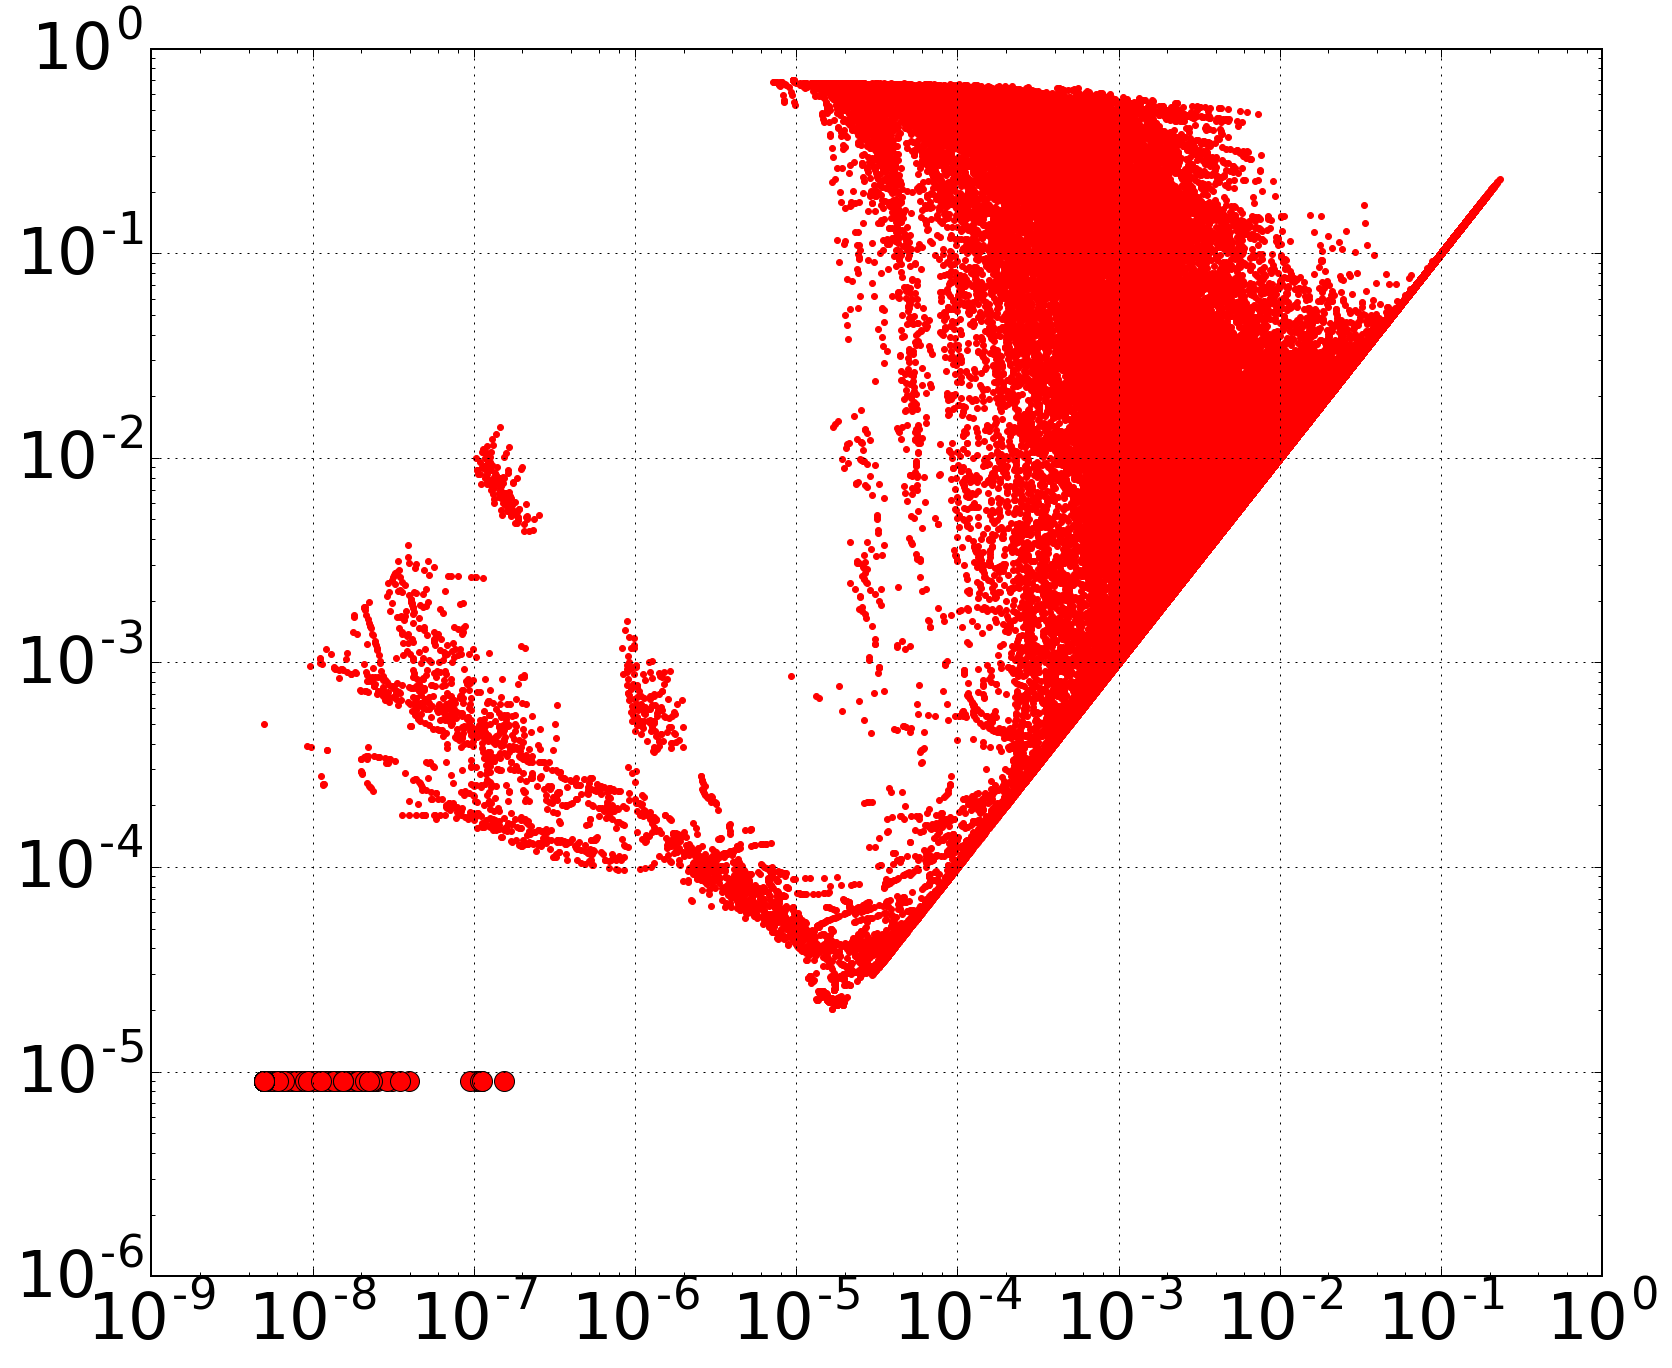

In [8]:
# Case 1, Don't enhance when fpol < 1e-5. Assume all stars formed are Pop III with Z_* < Z_crit

fpol  = 1.0-PPF
fpol[fpol < 1e-5]   = 0 # Don't enhance small polluted fractions... Later make these all Z_* < Z_crit

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5
Z_corr[Z_corr < 1e-5]    = 0.9e-5

plt.loglog(Z,Z_corr,'r.')
plt.loglog(Z[Z_corr==0.9e-5],Z_corr[Z_corr==0.9e-5],'ro',markersize=10)
plt.grid(axis='both')

print("Num pts < zcrit {}".format(len(Z_corr[Z_corr==0.9e-5])))
gc.collect()

In [9]:
baseAge = cosmo.ageAtz(71,z=z) # ageAtZ return Myr, parameters are H and z. Don't use astropy cosmology. Wrong answer
print("My cosmo age at {} = {:.3f}".format(z,baseAge * u.Myr))
print("Cosmo age at {} = {:.3f}".format(z,myCosmo.age(z).to(u.Myr)))
spAges = baseAge - bt/1e6
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
# print(baseAge - myCosmo.age(z).to(u.Myr).value)

My cosmo age at 9.0 = 562.006 Myr
Cosmo age at 9.0 = 559.195 Myr
min sp age 1.59 Myr
max sp age 362.90 Myr
min sp Z 5.00e-09 Solar
max sp Z 2.32e-01 Solar


In [62]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
tbox = sizeKeys[sizeKeys[::,0] == z][0,1]     # This works too.. 
# tbox = (3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc) # Last resort!
print("boxsize at z={:.2f} is {:.2f}".format(z,tbox))
halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos * 3000.0  # Comoving
locs = (locsRaw/boxsizekpc) * 3000.0 # Comoving coords of SPs
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

boxsize at z=12.00 is 324.44
Num of halos @ 12.0 = 182


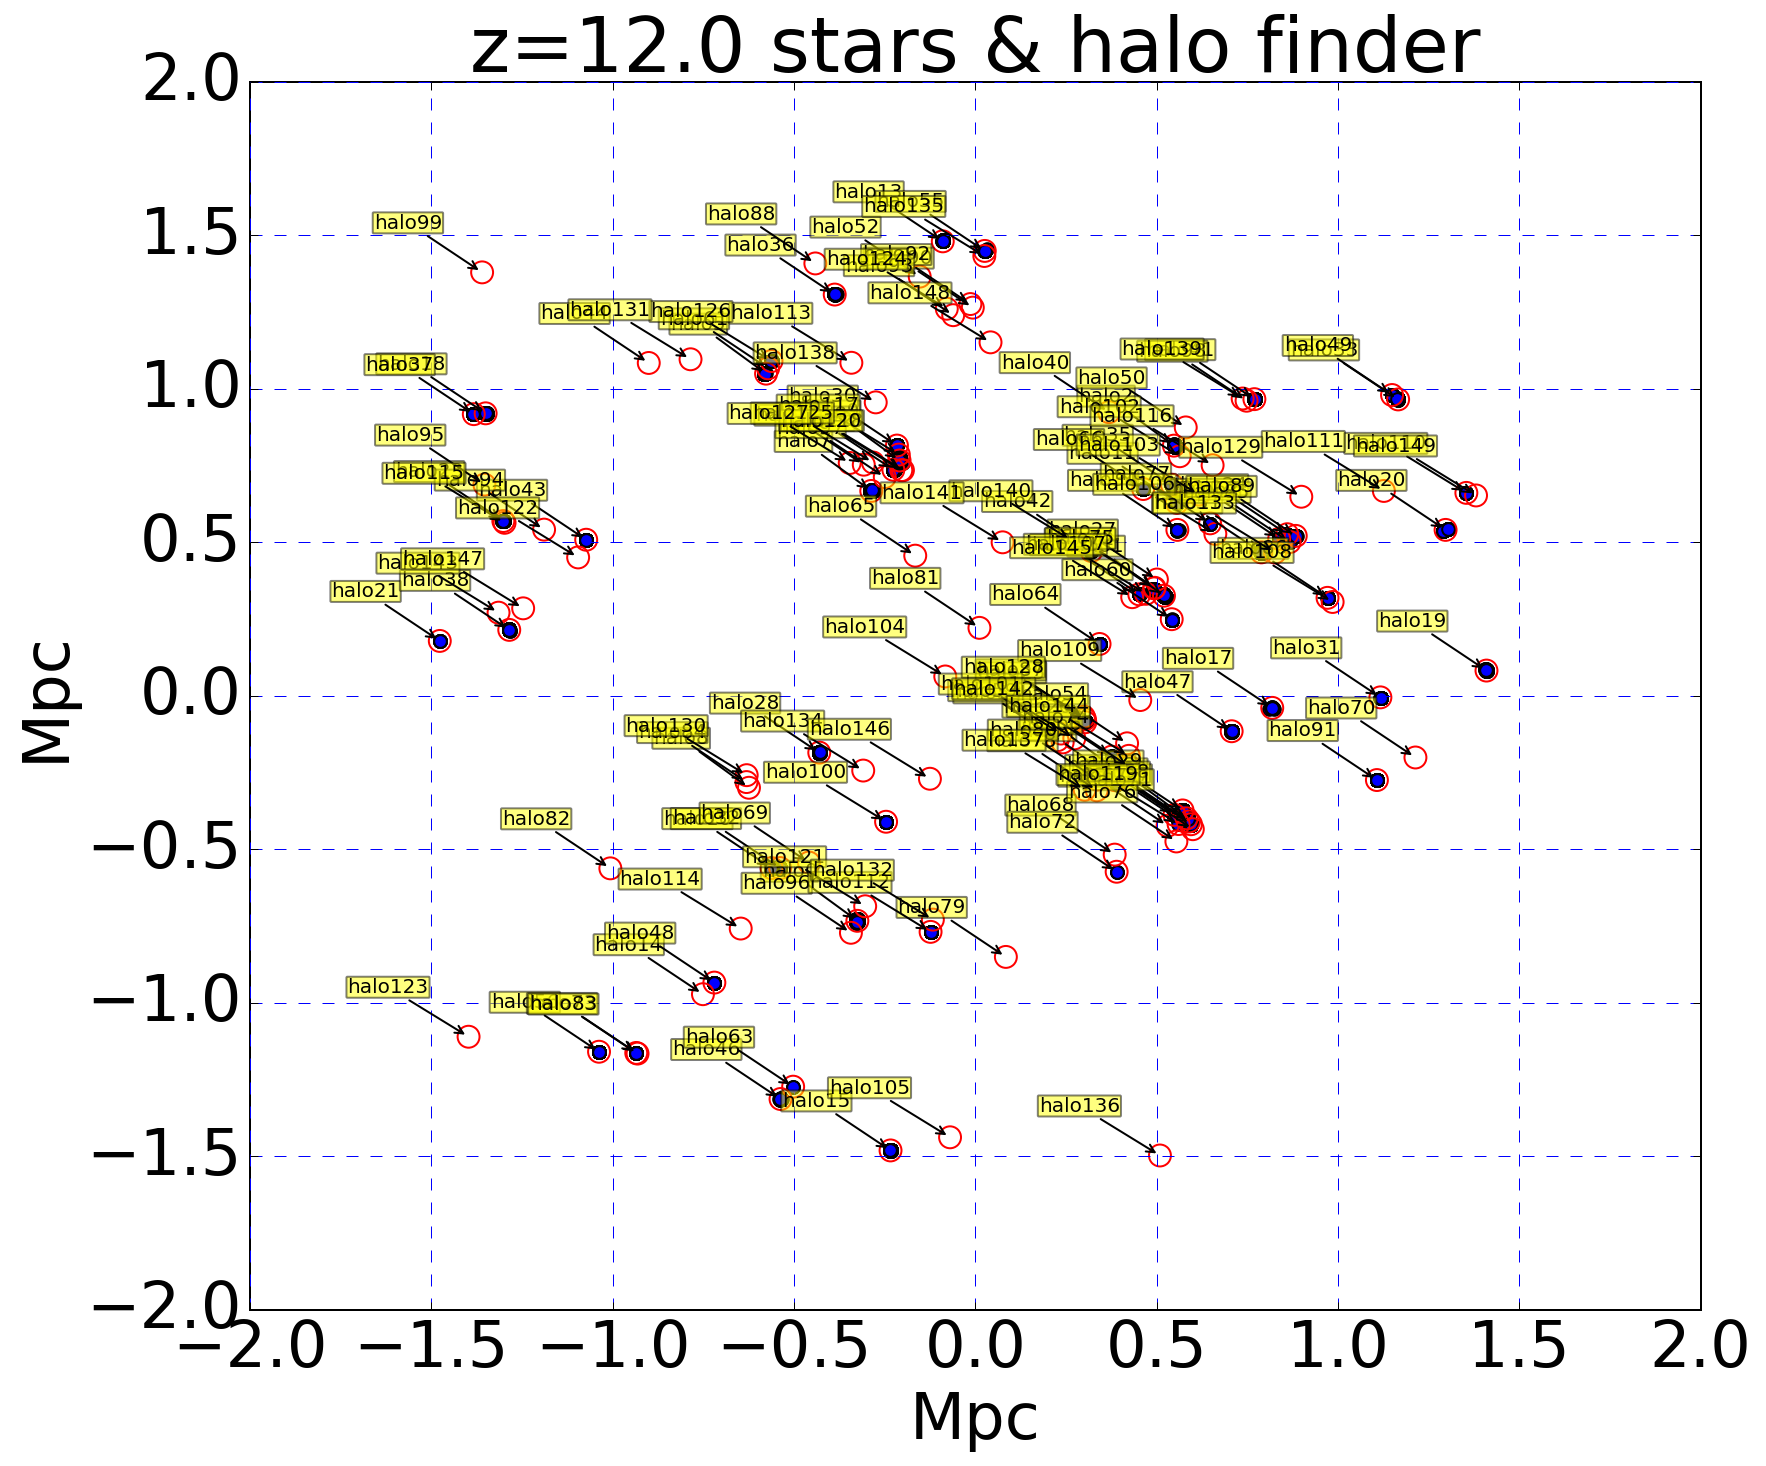

In [67]:
htp = min([150,len(halosRawPos)])
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0]/1000,halosPos[:htp,1]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

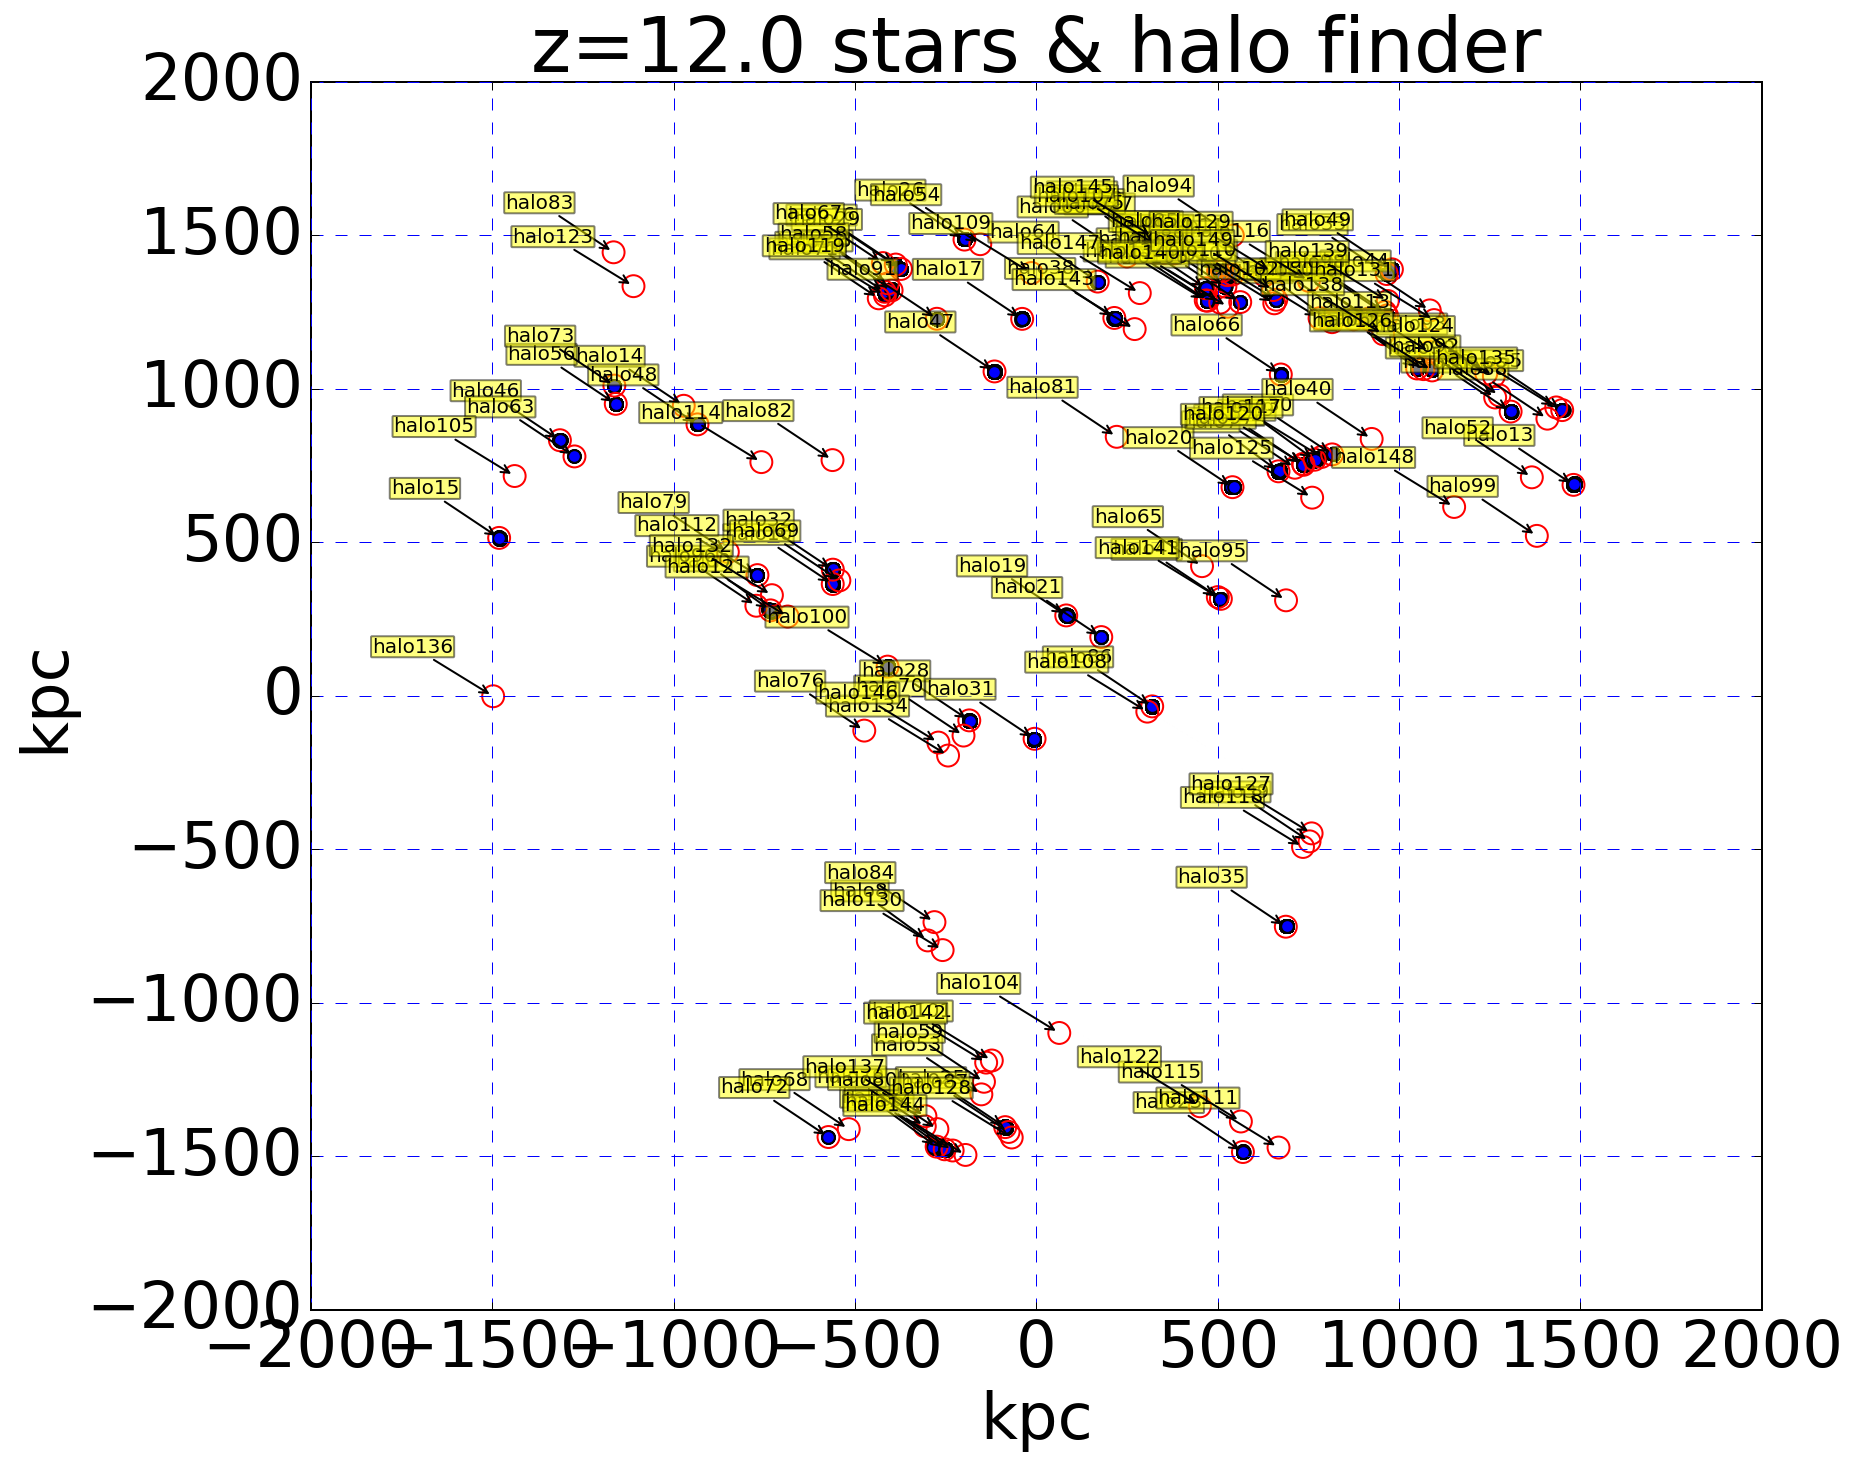

In [11]:
# Use the y-z plane
htp = min([150,len(halosRawPos)])
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,1],locs[:,2],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,1],halosPos[:htp,2],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,1],halosPos[:htp,2]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

/Users/earnric/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0

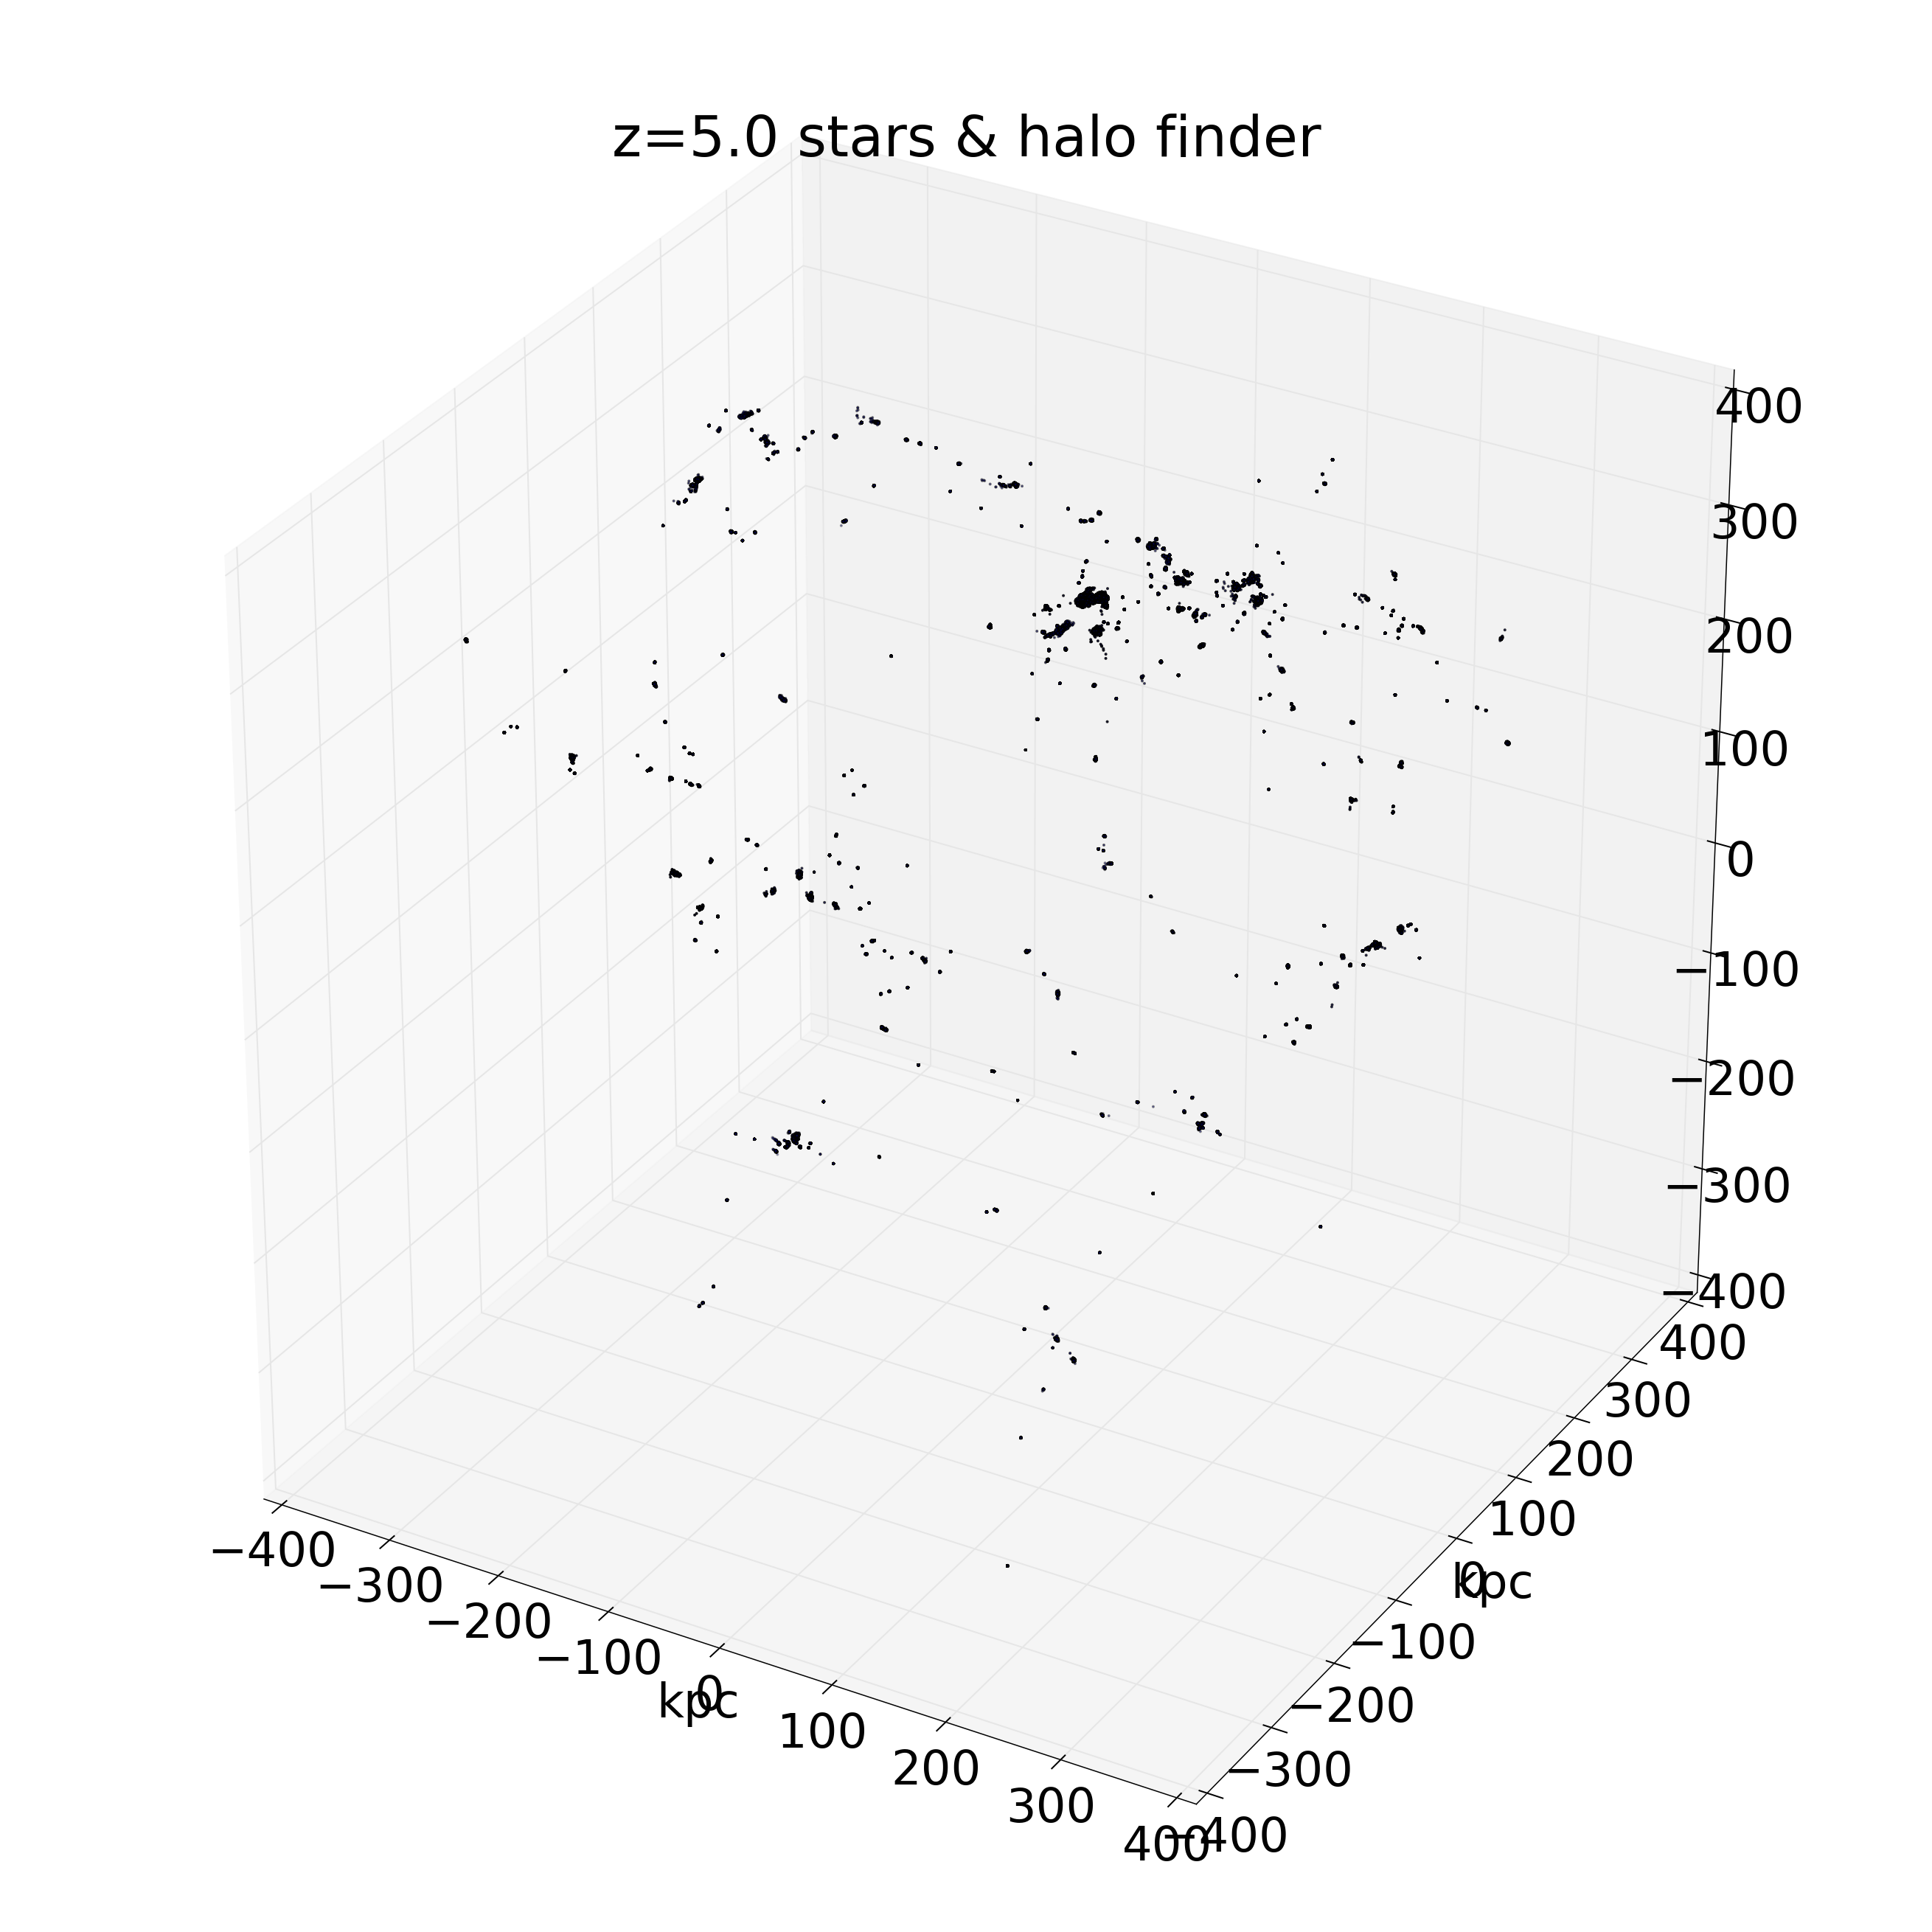

In [41]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['font.size'] = 14

fig = plt.figure(figsize=(18,18))
ax = Axes3D(fig)

htp = 100
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
# ax.scatter(halosPos[:htp,0],halosPos[:htp,1],halosPos[:htp,2],s=160,facecolor=(0,0,0,0), edgecolors='r') # Plot halo locs
ax.scatter(locs[:,0],locs[:,1],locs[:,2],s=1,c='b') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('kpc')
ax.set_ylabel('kpc')
ax.set_title('z=%.1lf stars & halo finder'%z)
# for label, x, y, zz  in zip(labels, halosPos[:htp,0],halosPos[:htp,1],halosPos[:htp,2]):
#     ax.text(x,y,zz, label, size=10, color='y')    
fig.show()
plt.rcParams['font.size'] = 32
gc.collect()

1541

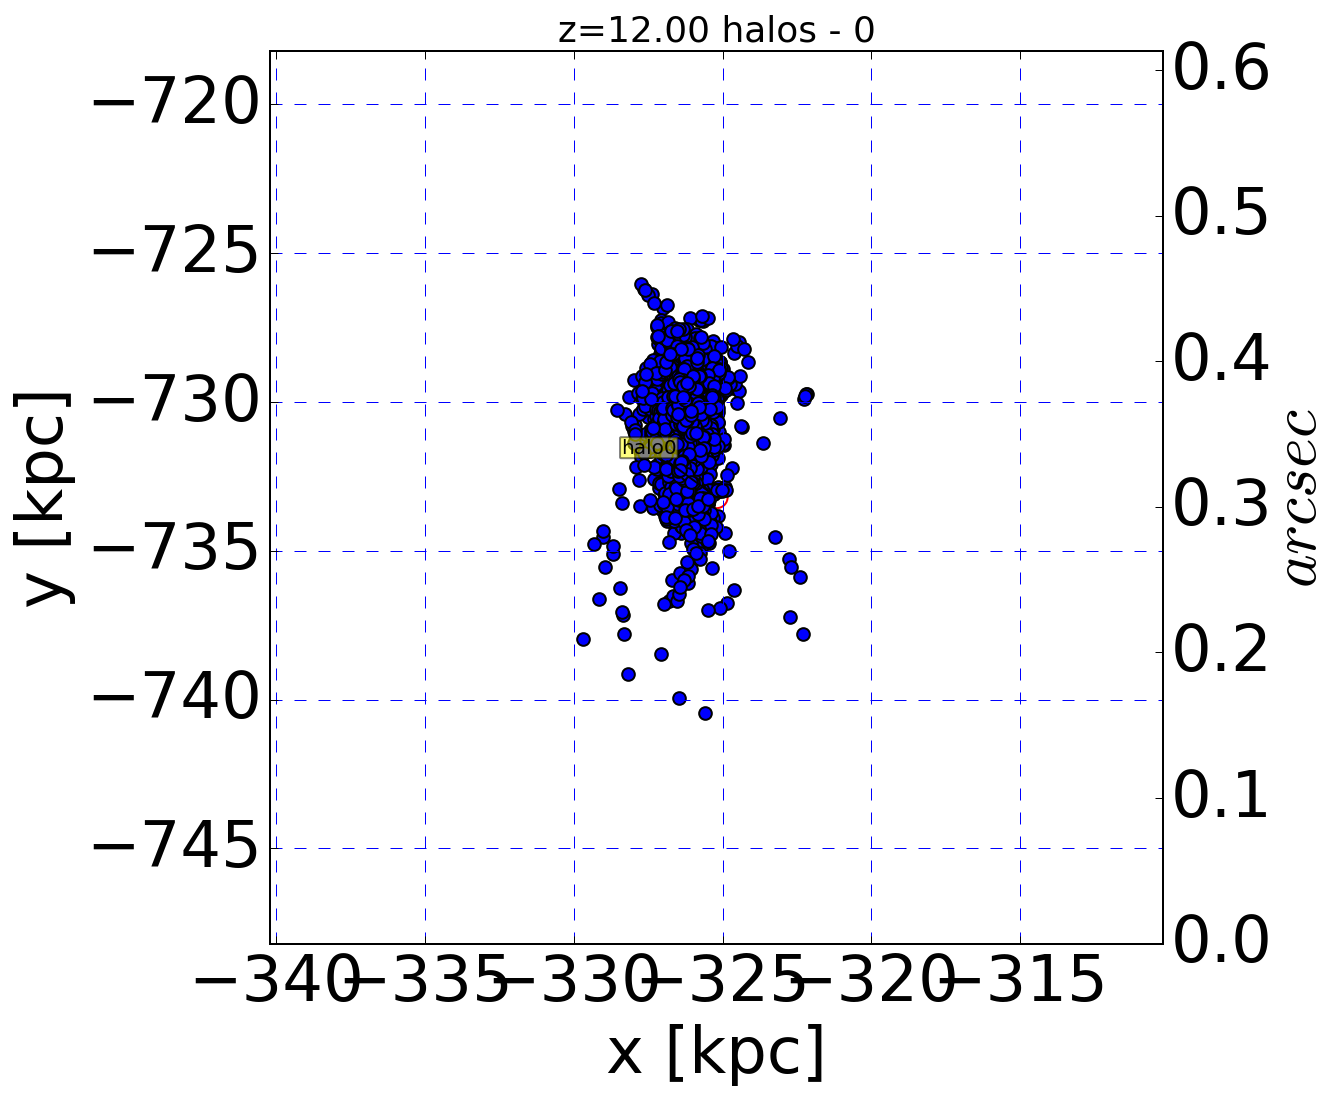

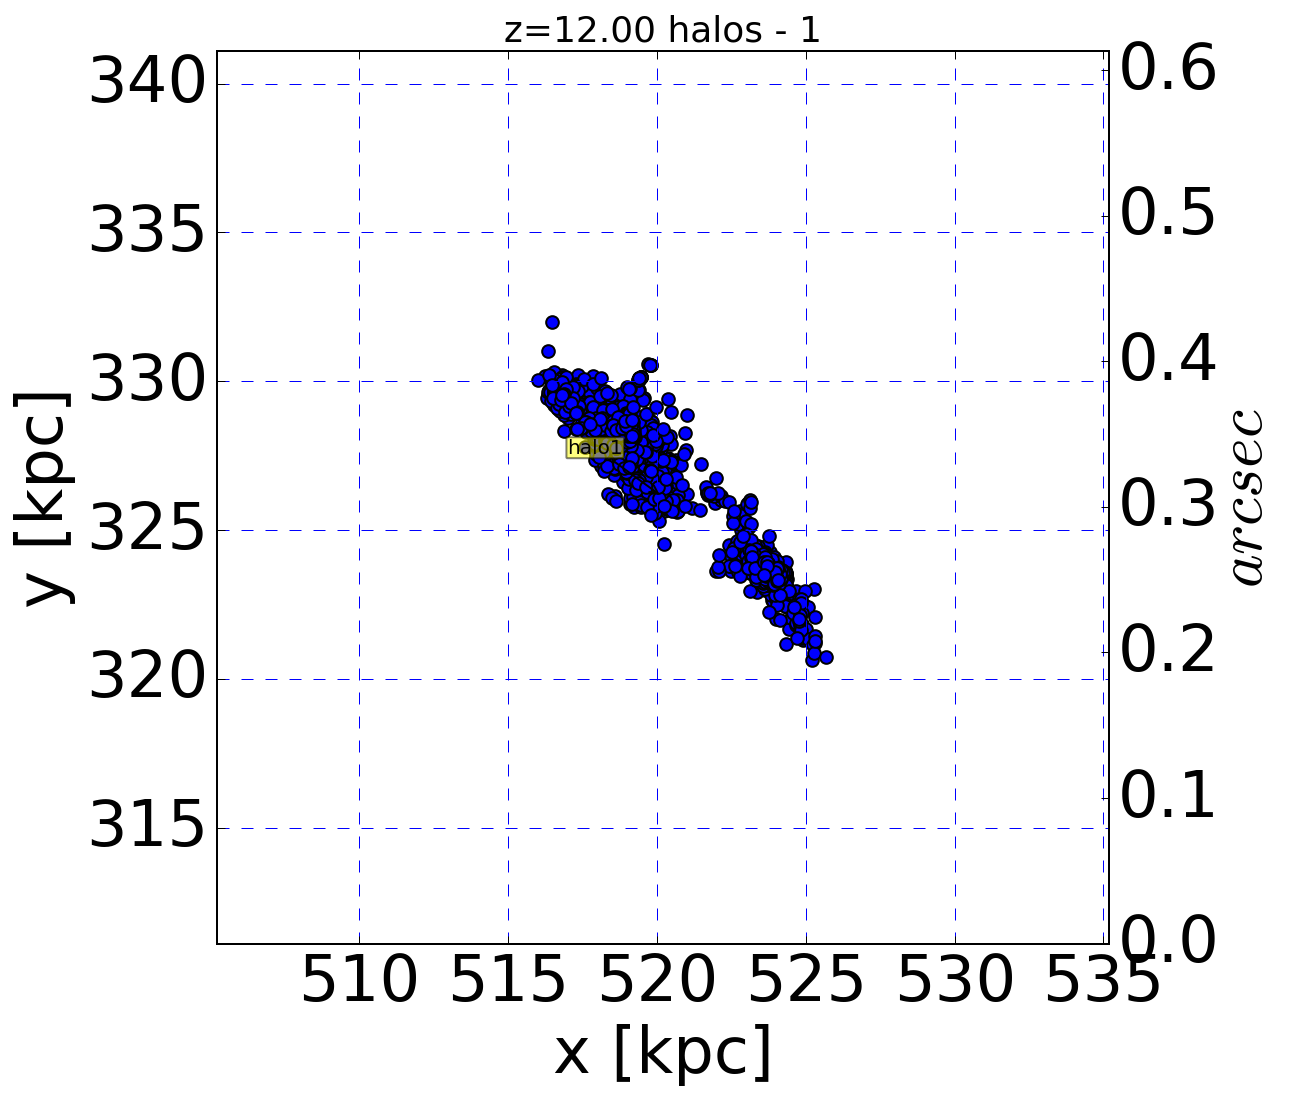

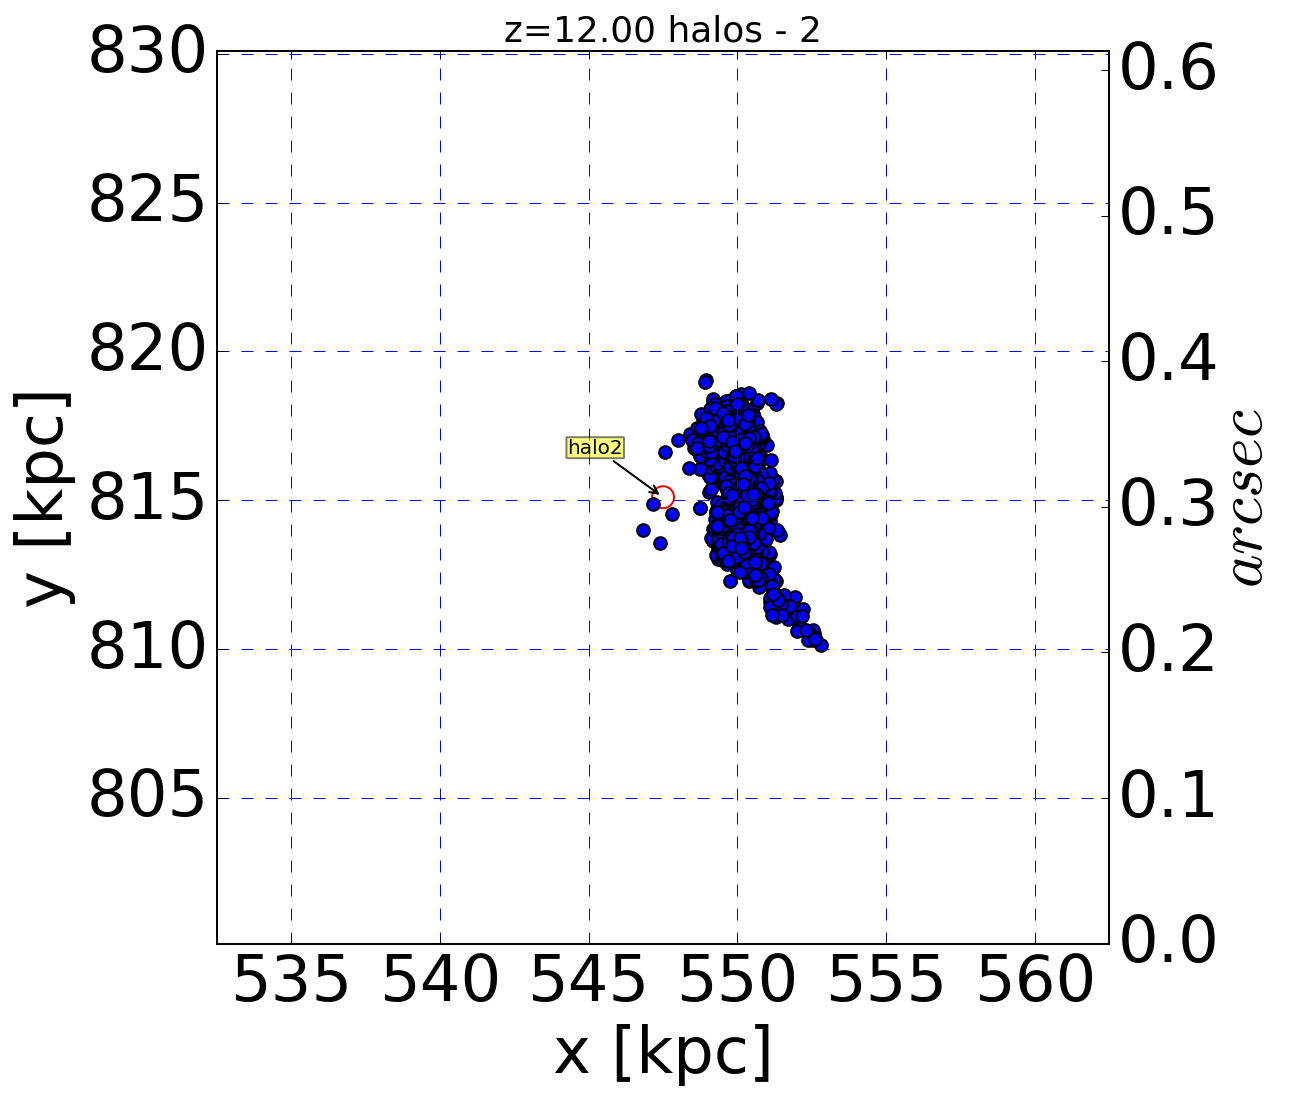

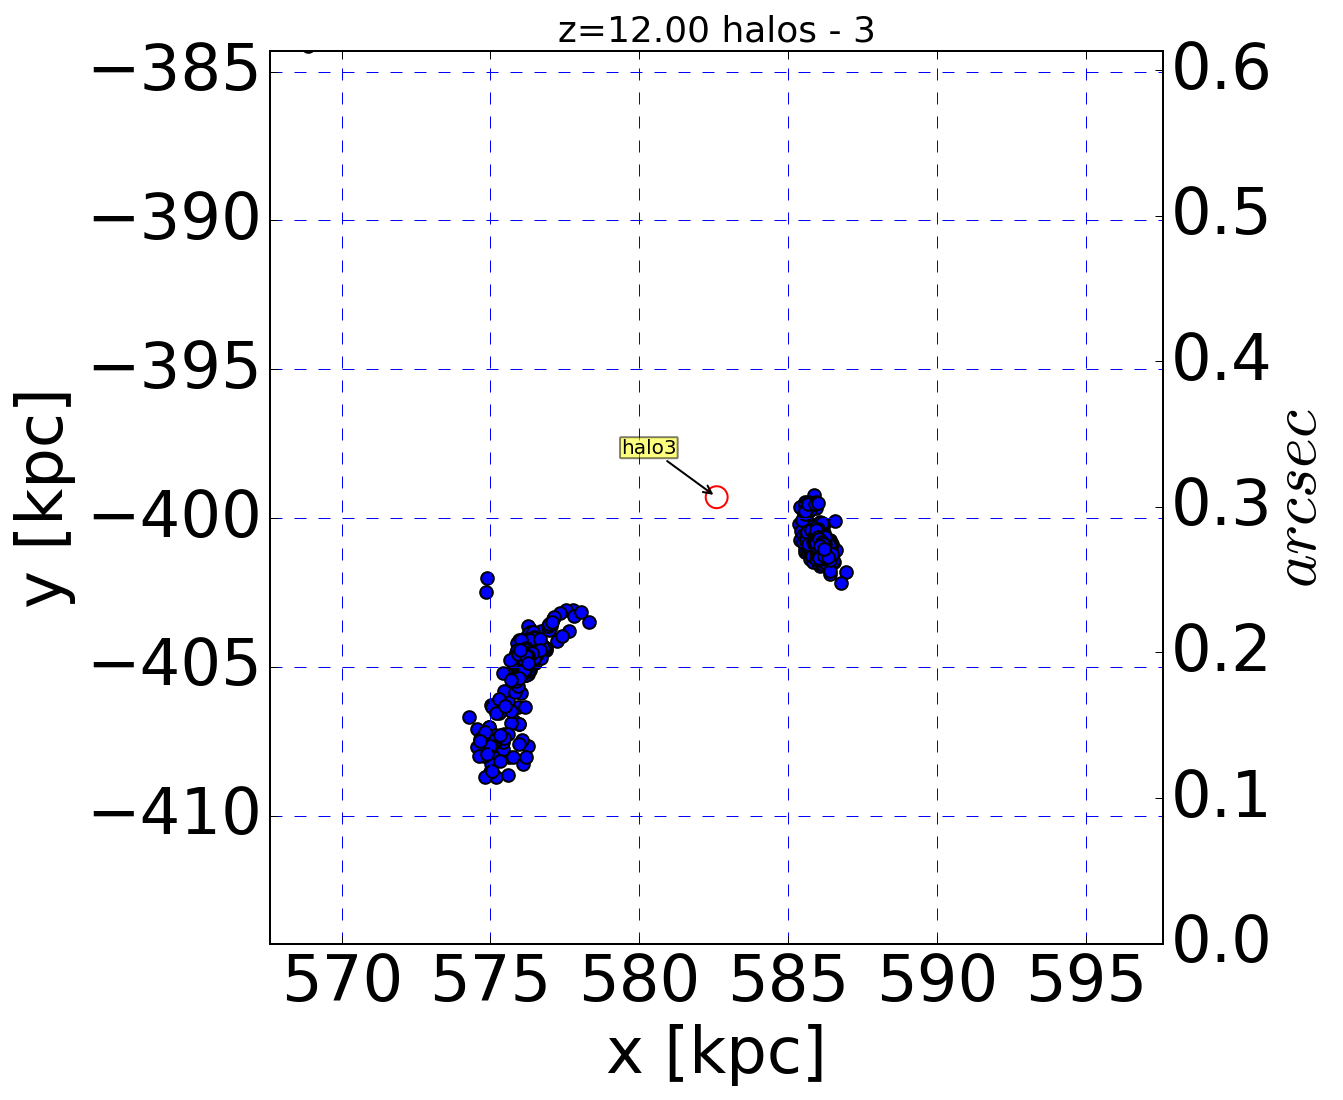

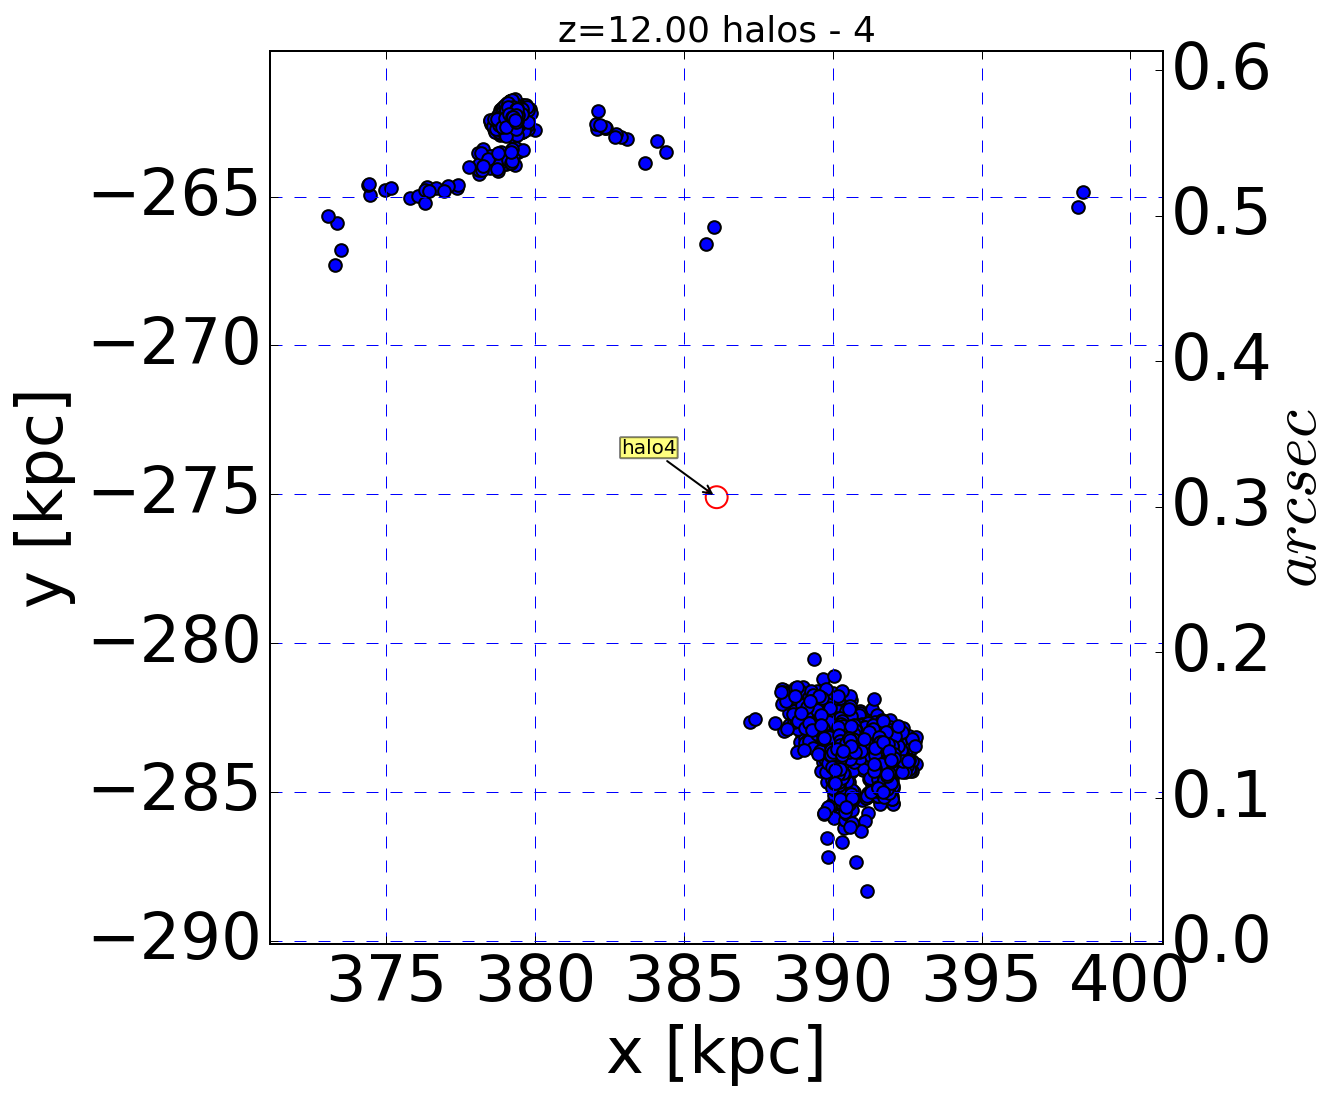

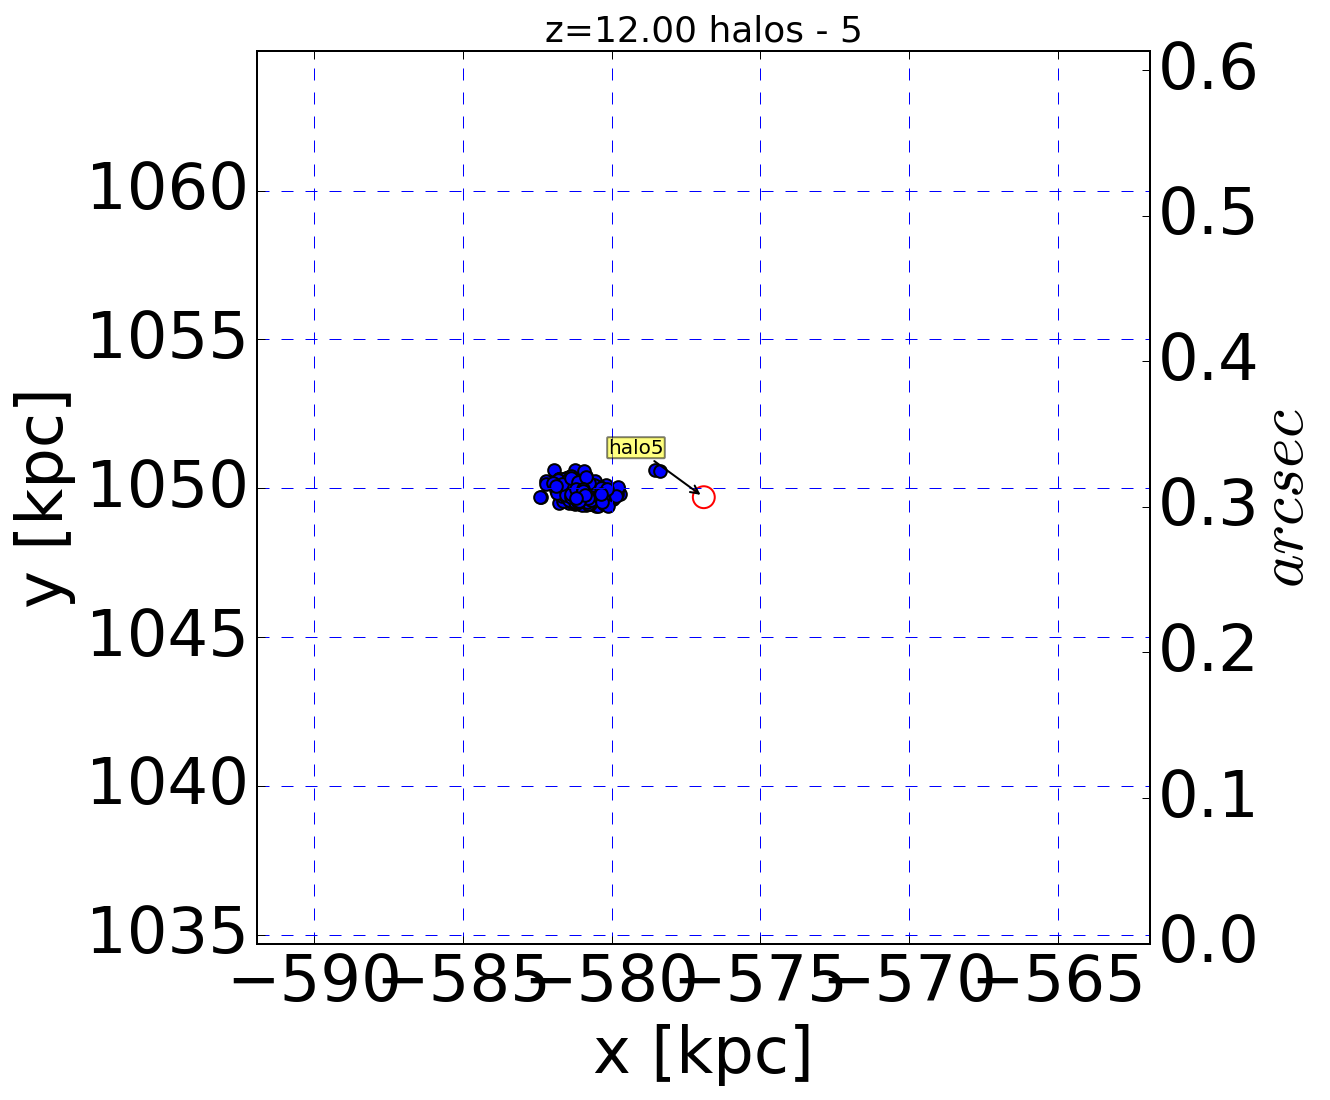

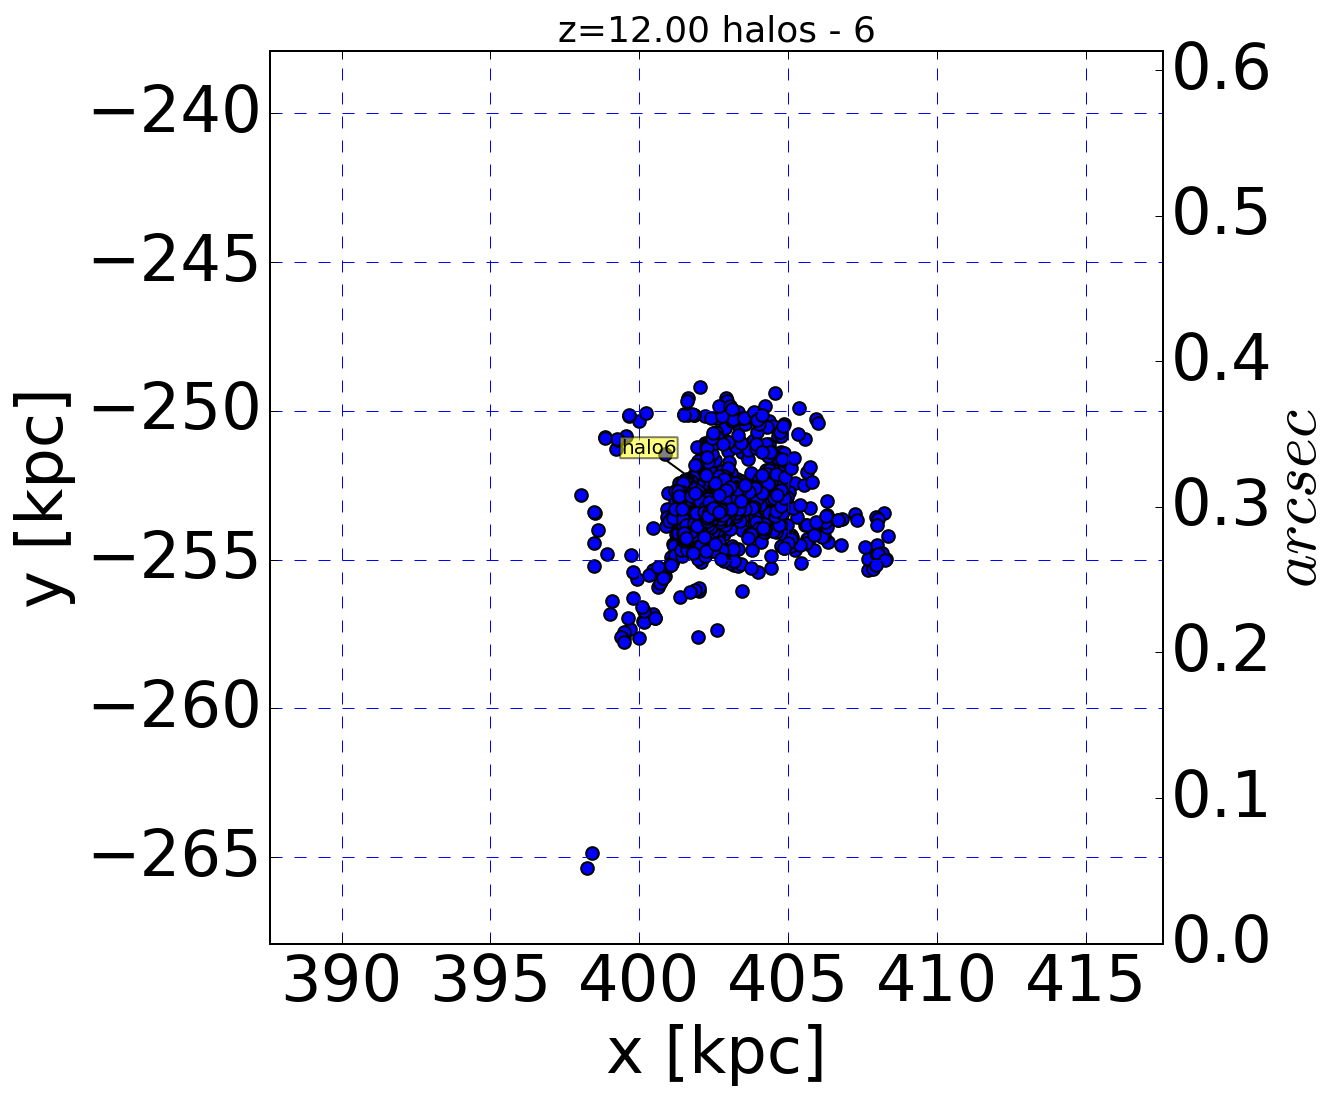

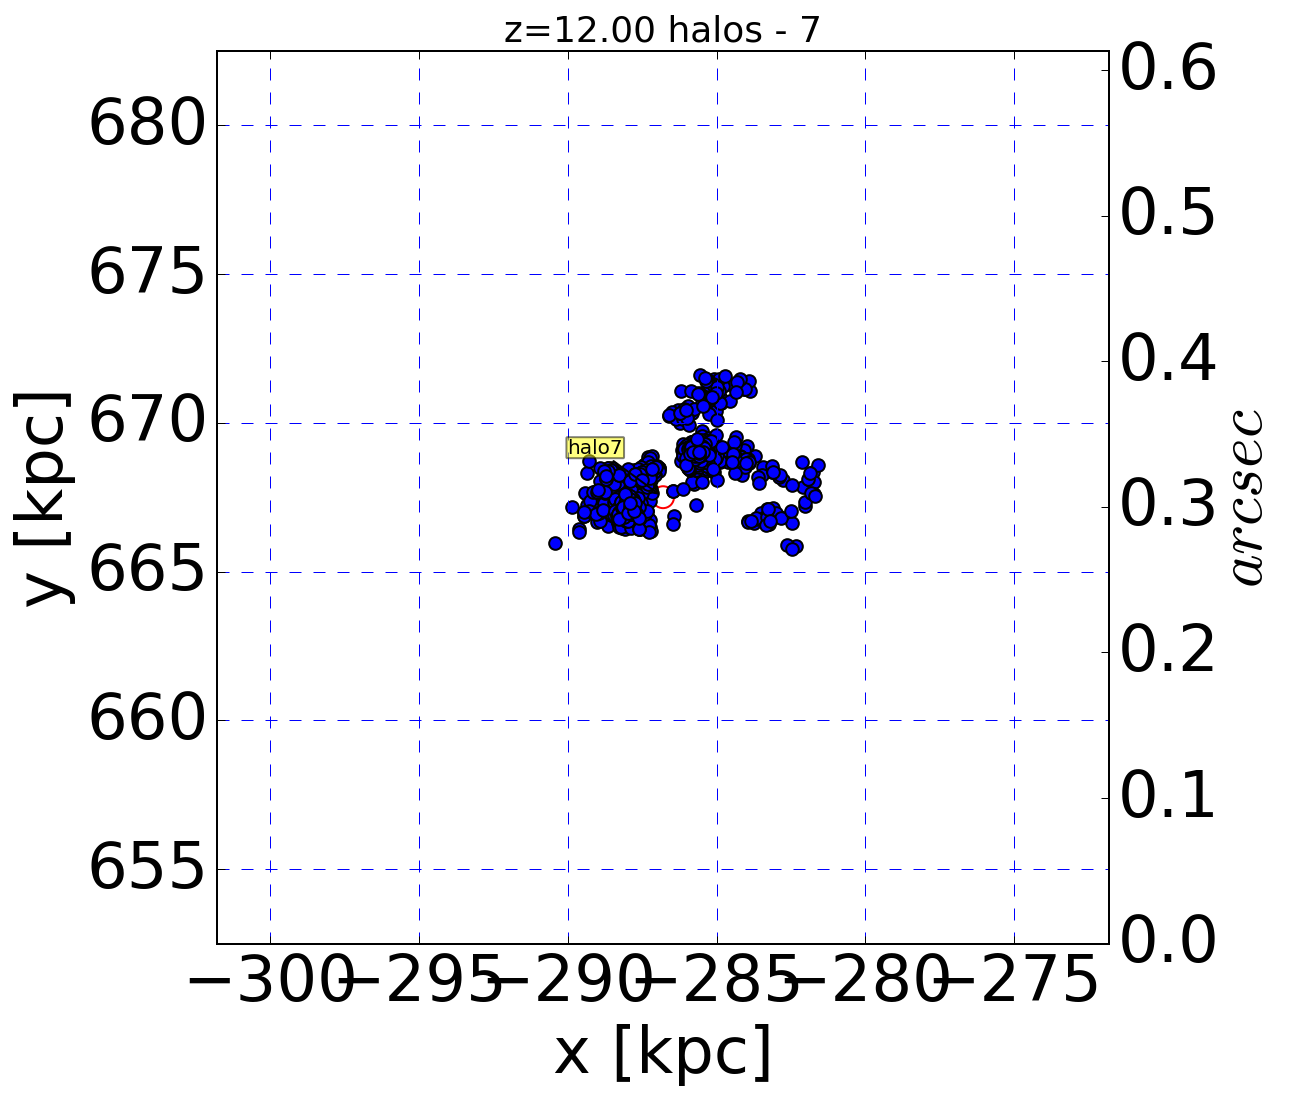

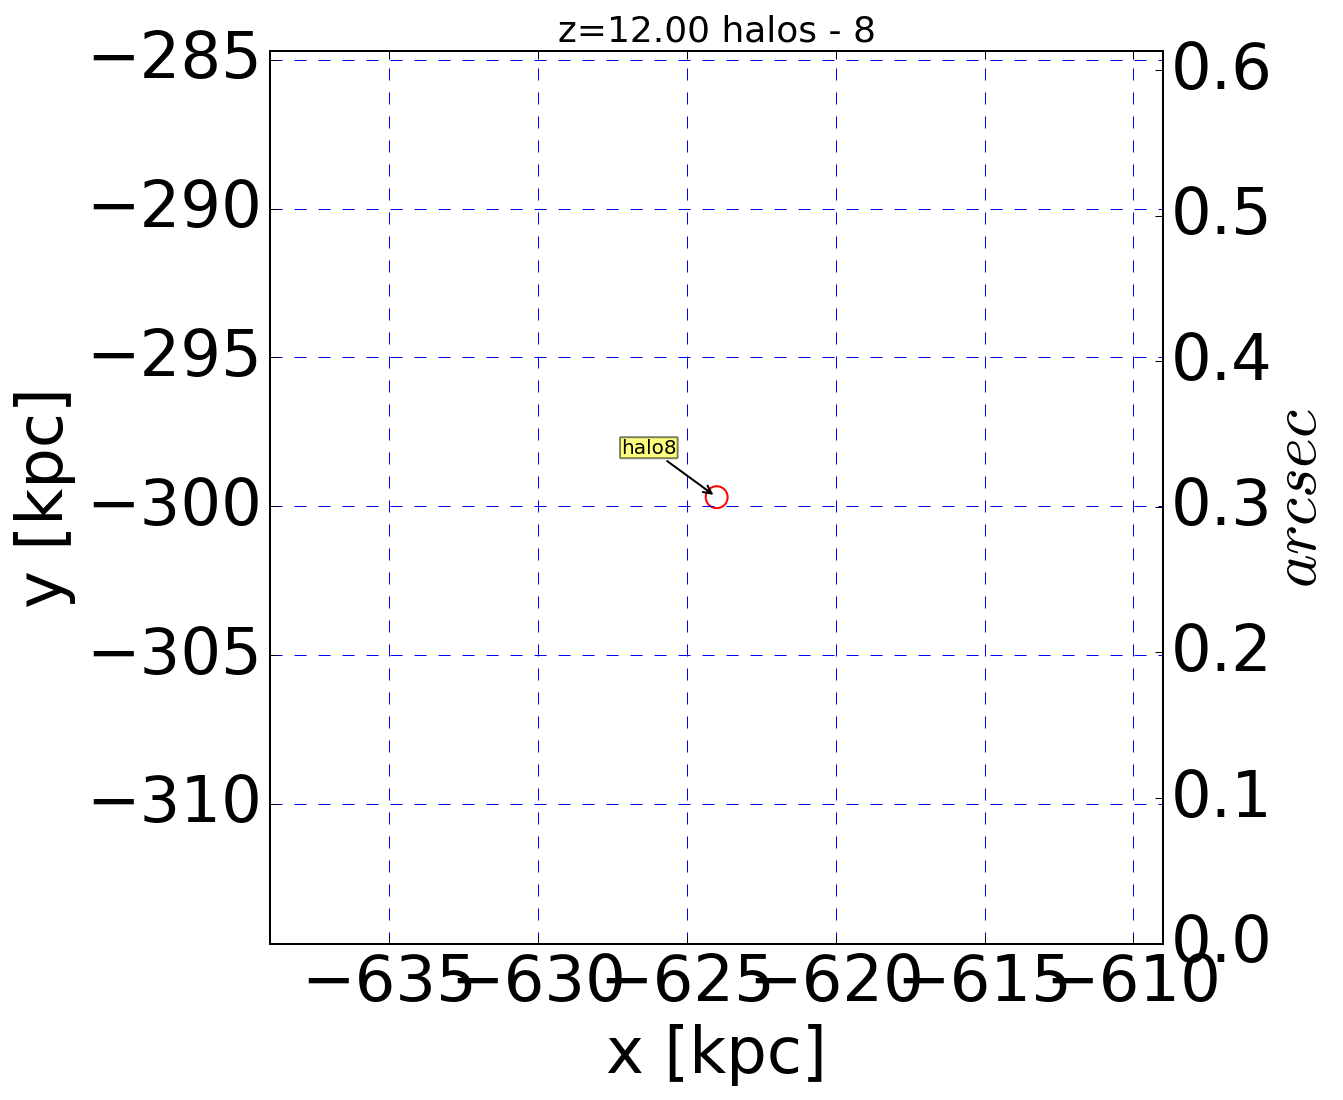

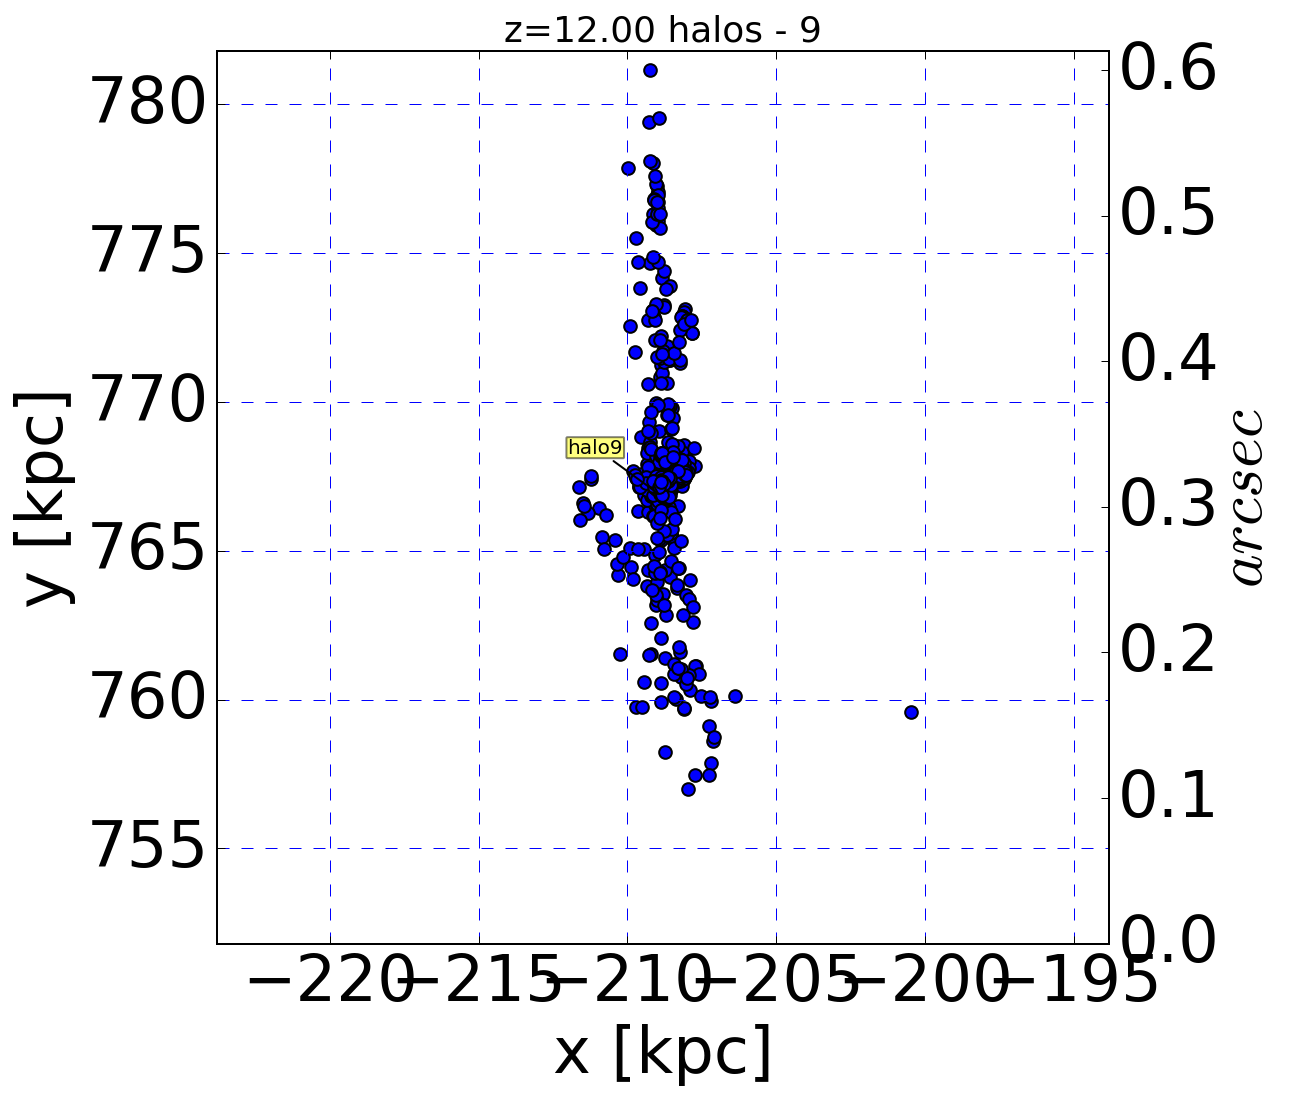

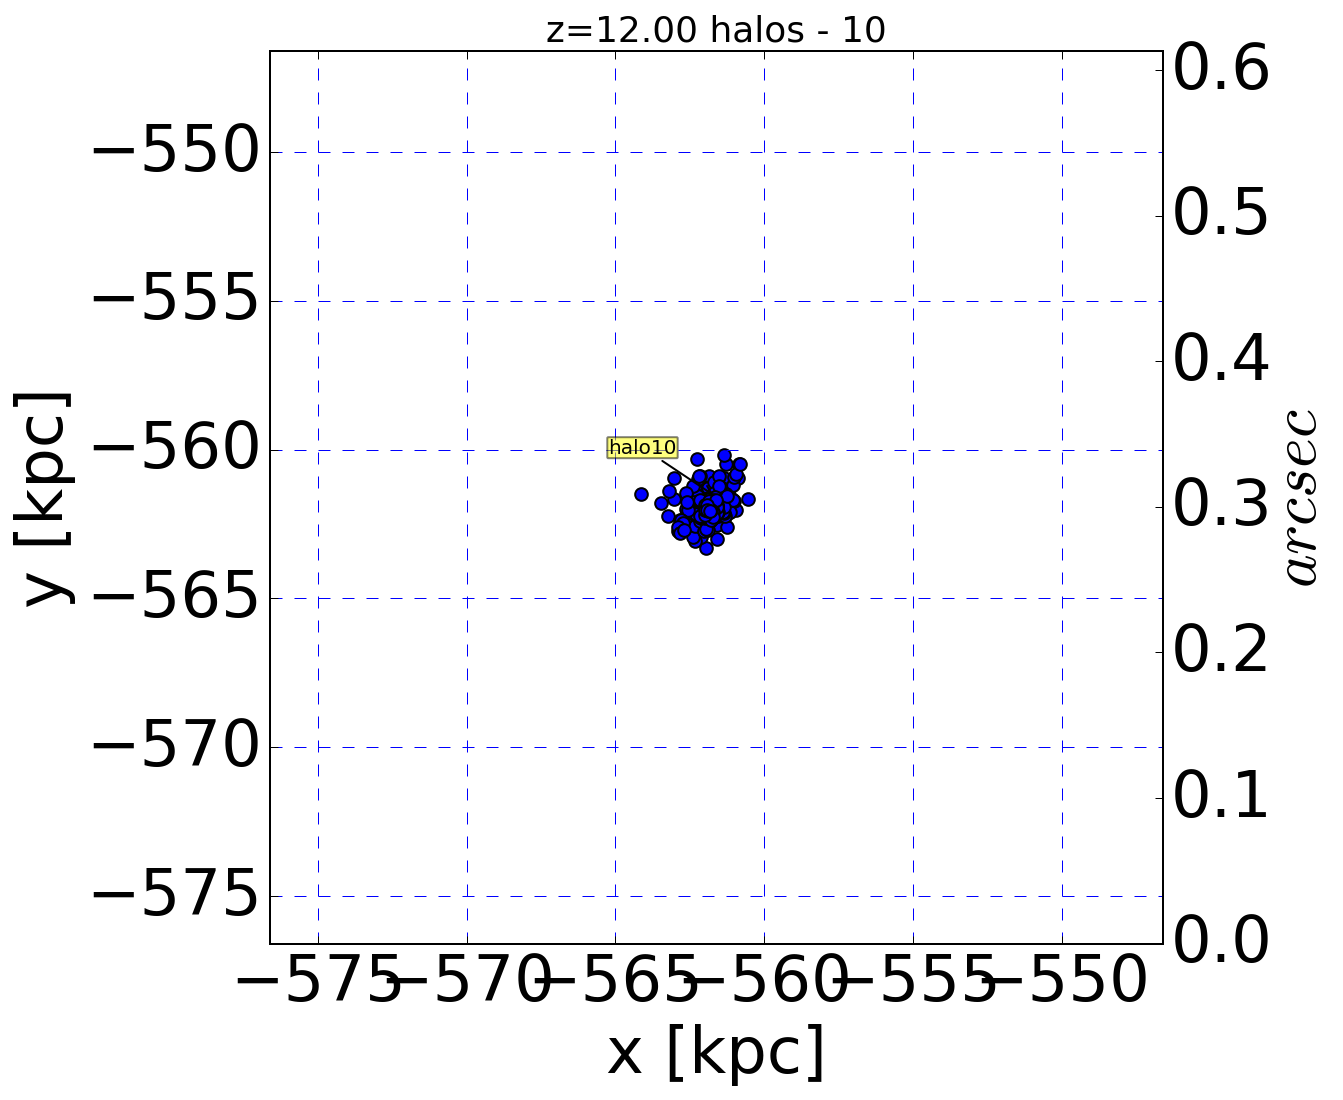

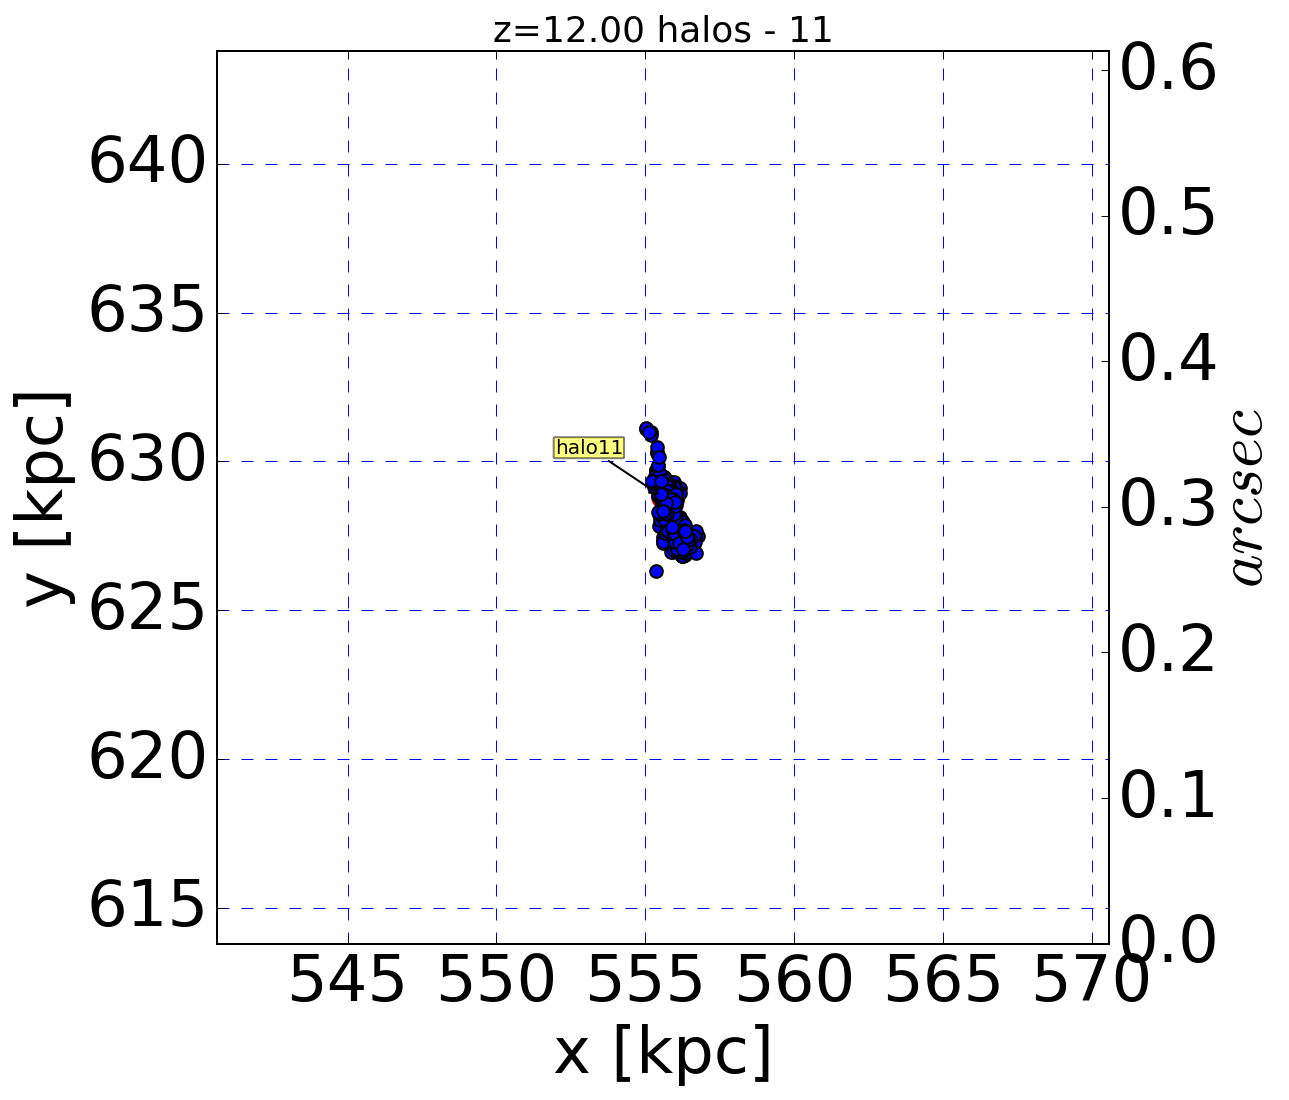

In [12]:
size = 5.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = 30
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
for halo in range(0,12):
    ax=halos.pltView(locs,halosPos,halo,z,size)
    hax2 = ax.twinx()
    hax2.set_ylim([0,size * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
gc.collect()

In [15]:
size = 20 # kpc
numZeros = 0
nonZeros = 0
for indx,h in enumerate(halosPos):
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,indx,size)
    if (len(halospmass) > 0):
        nonZeros += 1
    else:
        numZeros += 1
print('Num zero len halos', numZeros)
print('Non zero len halos', nonZeros)

Num zero len halos 96
Non zero len halos 86


# Plot halo-specific histograms

Load the relevant data from min/max age & min/max Z @ redshift we are working
For array that map to lower Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at lower Z at exact age
For array that map to upper Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at upper Z at exact age
Interpolate value at exact Z using exact age value at lower/uppper Z

In [14]:
from scipy.interpolate import interp1d

In [15]:
pop3Flux14 = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',',names=True)
Zem7Flux14 = np.genfromtxt('Zem7_14.0.gz',dtype=float, delimiter=',',names=True)

In [16]:
pop3Flux14['f210m'][pop3Flux14['LogAge'] == 4.0], Zem7Flux14['f210m'][Zem7Flux14['LogAge'] == 4.0]

(array([  2.86740000e-38]), array([  4.89540000e-39]))

In [17]:
print(pop3Flux14.dtype.names)

('LogAge', 'redshift', 'f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


419

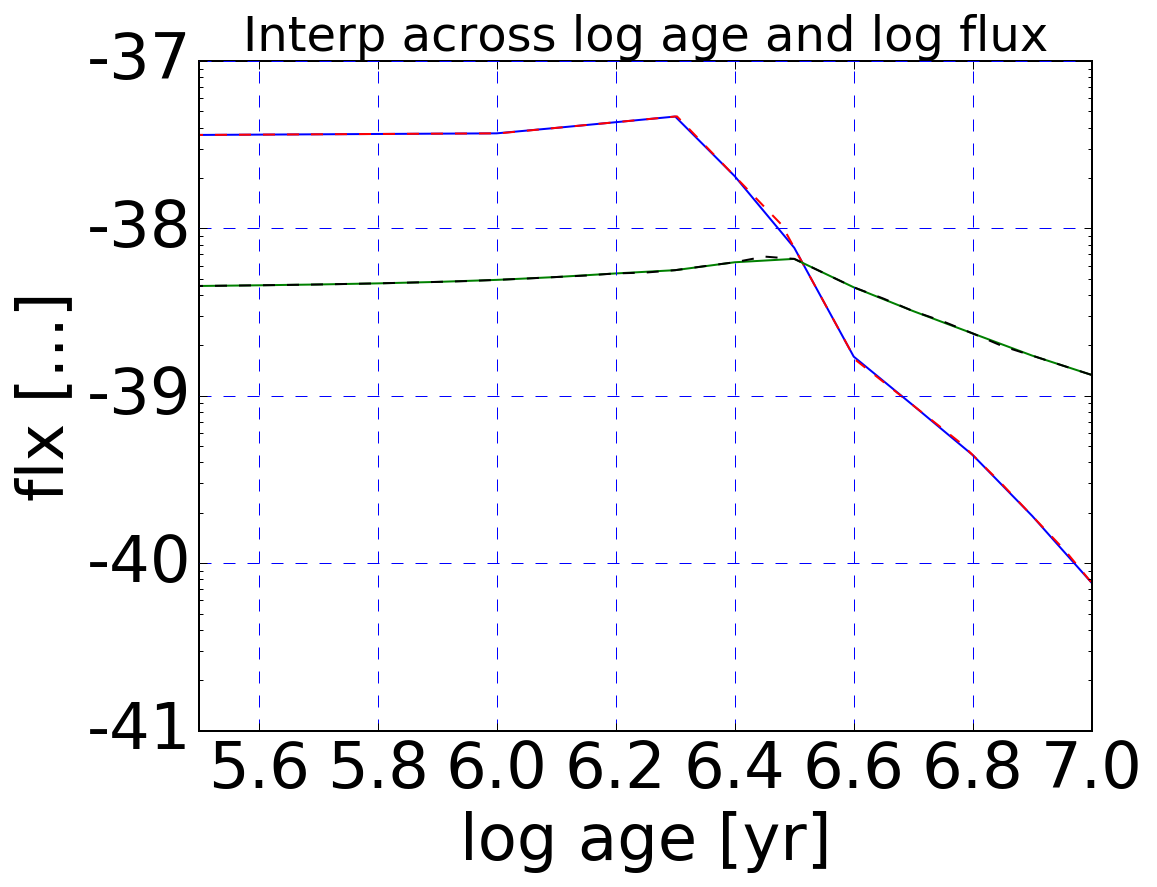

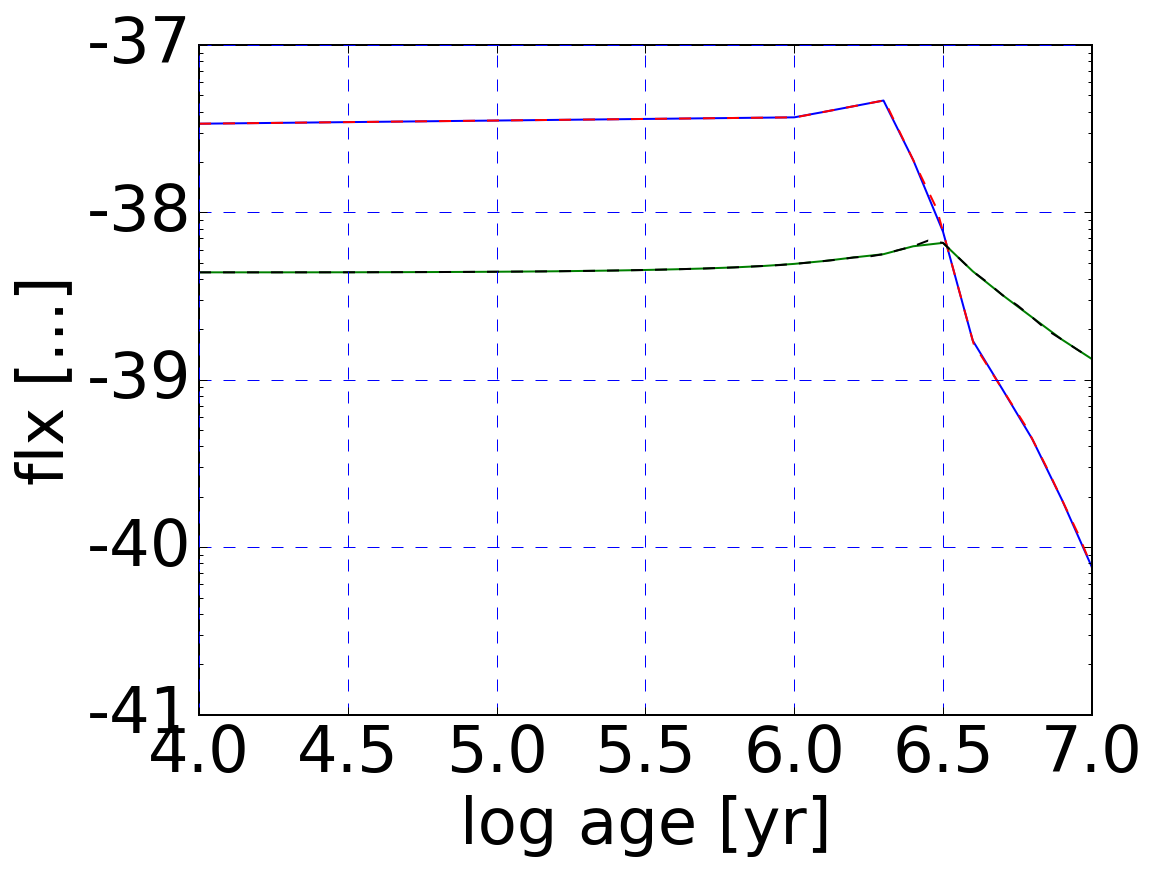

In [18]:
# How about an interpolating function for each file (2 files for upper/lower Z)\
# Tested using Log Age for the interp on 8 Aug --- interpolate using LOG age provides a closer fit to 
# the orig curve
pop3Flux14Interp = interp1d(pop3Flux14['LogAge'],np.log10(pop3Flux14['f335m']),kind='linear')
Zem7Flux14Interp = interp1d(Zem7Flux14['LogAge'],np.log10(Zem7Flux14['f335m']),kind='linear')

logAgeRng = np.arange(4,9,0.1)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,10**pop3Flux14Interp(logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,10**Zem7Flux14Interp(logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([5.5,7])
ax.set_ylim([1e-41,1e-37])
ax.set_title('Interp across log age and log flux',size=24)

gc.collect()

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,10**pop3Flux14Interp(logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,10**Zem7Flux14Interp(logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([4,7])
ax.set_ylim([1e-41,1e-37])
    
gc.collect()

In [58]:
# Best to use Log Age, Log Flux

In [59]:
import logInterp

419

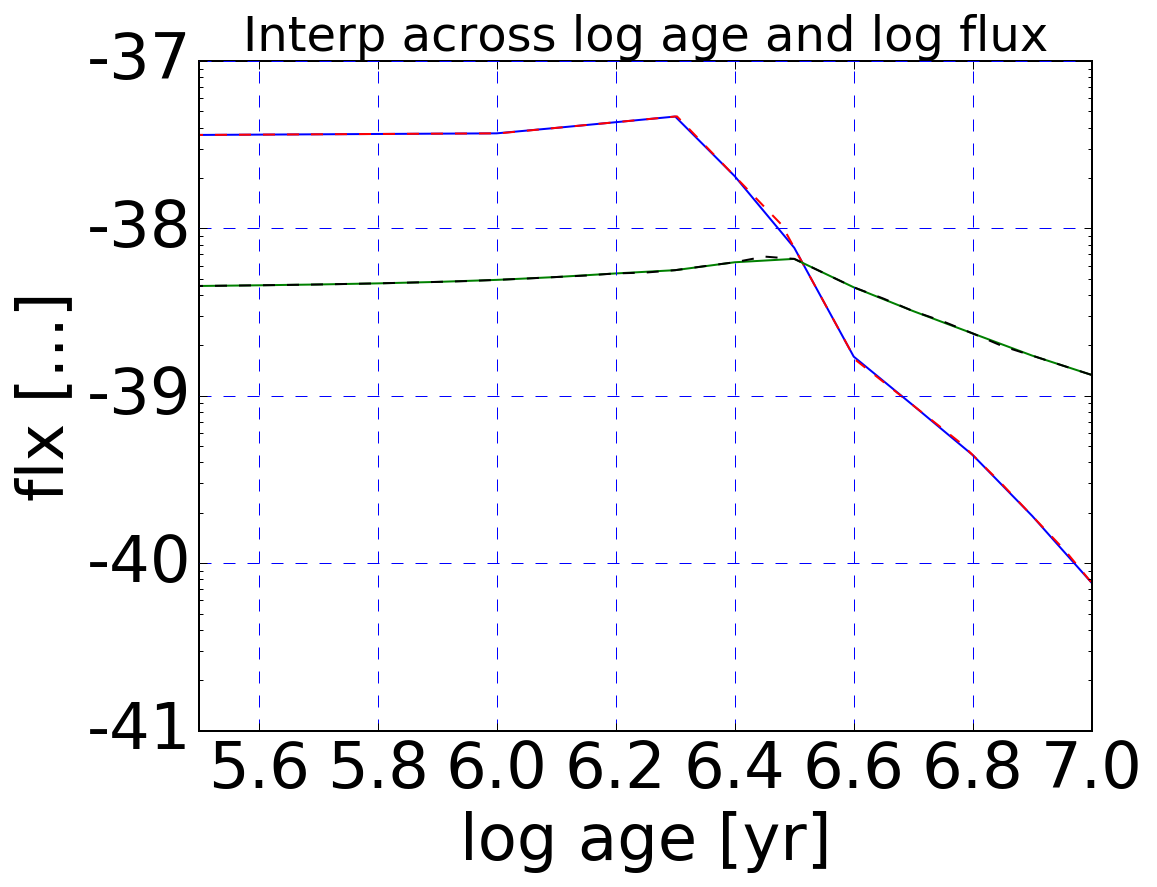

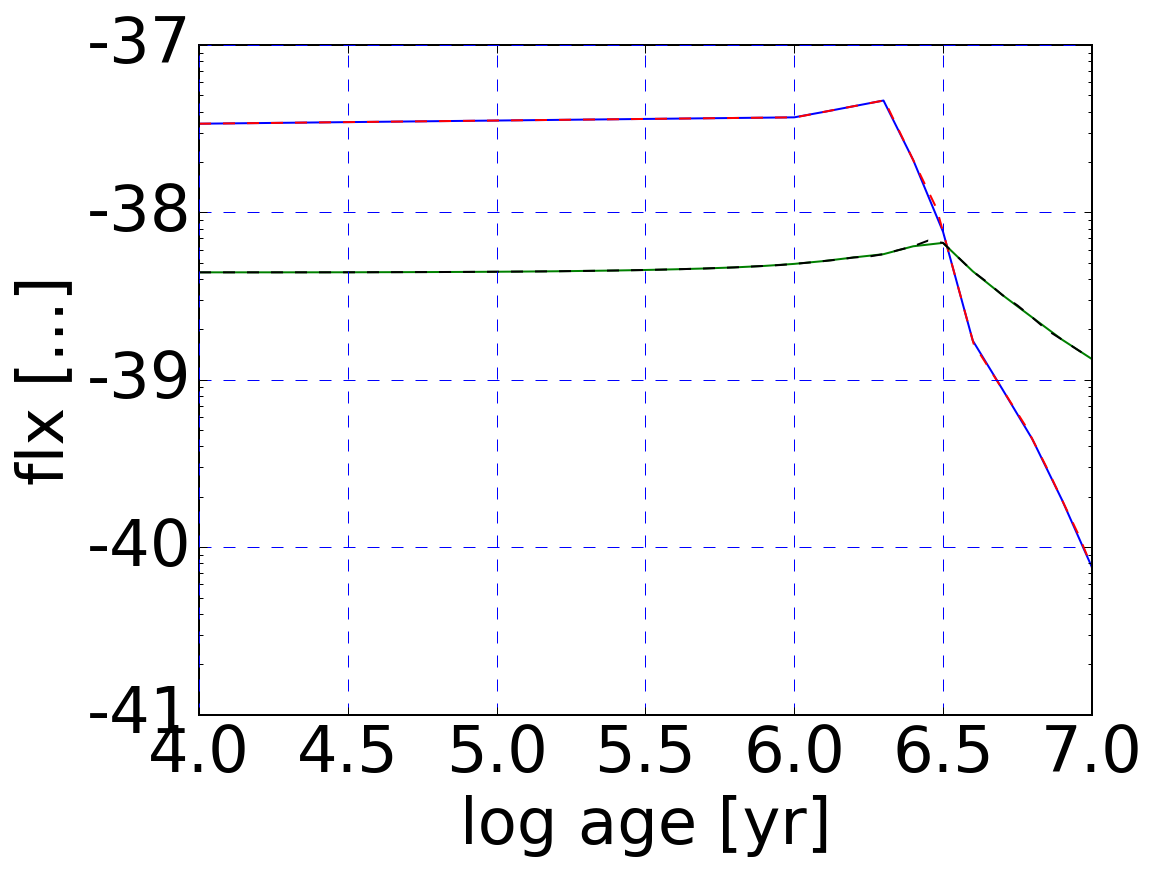

In [24]:
# How about an interpolating function for each file (2 files for upper/lower Z)\
# USING my LIBRARY LOG INTERP routine... 
pop3Flux14Interp = logInterp.log_interp1d(10**pop3Flux14['LogAge'],pop3Flux14['f335m'])
Zem7Flux14Interp = logInterp.log_interp1d(10**Zem7Flux14['LogAge'],Zem7Flux14['f335m'])

logAgeRng = np.arange(4,9,0.1)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,pop3Flux14Interp(10**logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,Zem7Flux14Interp(10**logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([5.5,7])
ax.set_ylim([1e-41,1e-37])
ax.set_title('Interp across log age and log flux',size=24)

gc.collect()

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(logAgeRng,pop3Flux14Interp(10**logAgeRng),'b') # Plot star particles
ax.plot(pop3Flux14['LogAge'],pop3Flux14['f335m'],'r--') # Plot star particles
ax.plot(logAgeRng,Zem7Flux14Interp(10**logAgeRng),'g') # Plot star particles
ax.plot(Zem7Flux14['LogAge'],Zem7Flux14['f335m'],'k--') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log age [yr]')
ax.set_ylabel('flx [...]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xlim([4,7])
ax.set_ylim([1e-41,1e-37])
    
gc.collect()

In [25]:
print('min/max Myr',spAges.min(),spAges.max())
np.log10([spAges.min()*1e6,spAges.max()*1e6])

min/max Myr 1.2433390104 180.149774355


array([ 6.09458956,  8.25563372])

In [26]:
print('min/max Z',Z.min()*0.02,Z.max()*0.02)
# Remember, Z = 1e-10 as a mass fraction is essentially Z = 0.0

min/max Z 1e-10 0.0022516272172


In [27]:
pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)

(2.9417225199544863e-38, 4.3844999999999689e-39)

In [28]:
#
# USE A LOG interpolation now that we have filter flux for our age range in two interpolating functions
#
filt335mInterp = logInterp.log_interp1d([1e-100,1e-7],[pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)])

20593

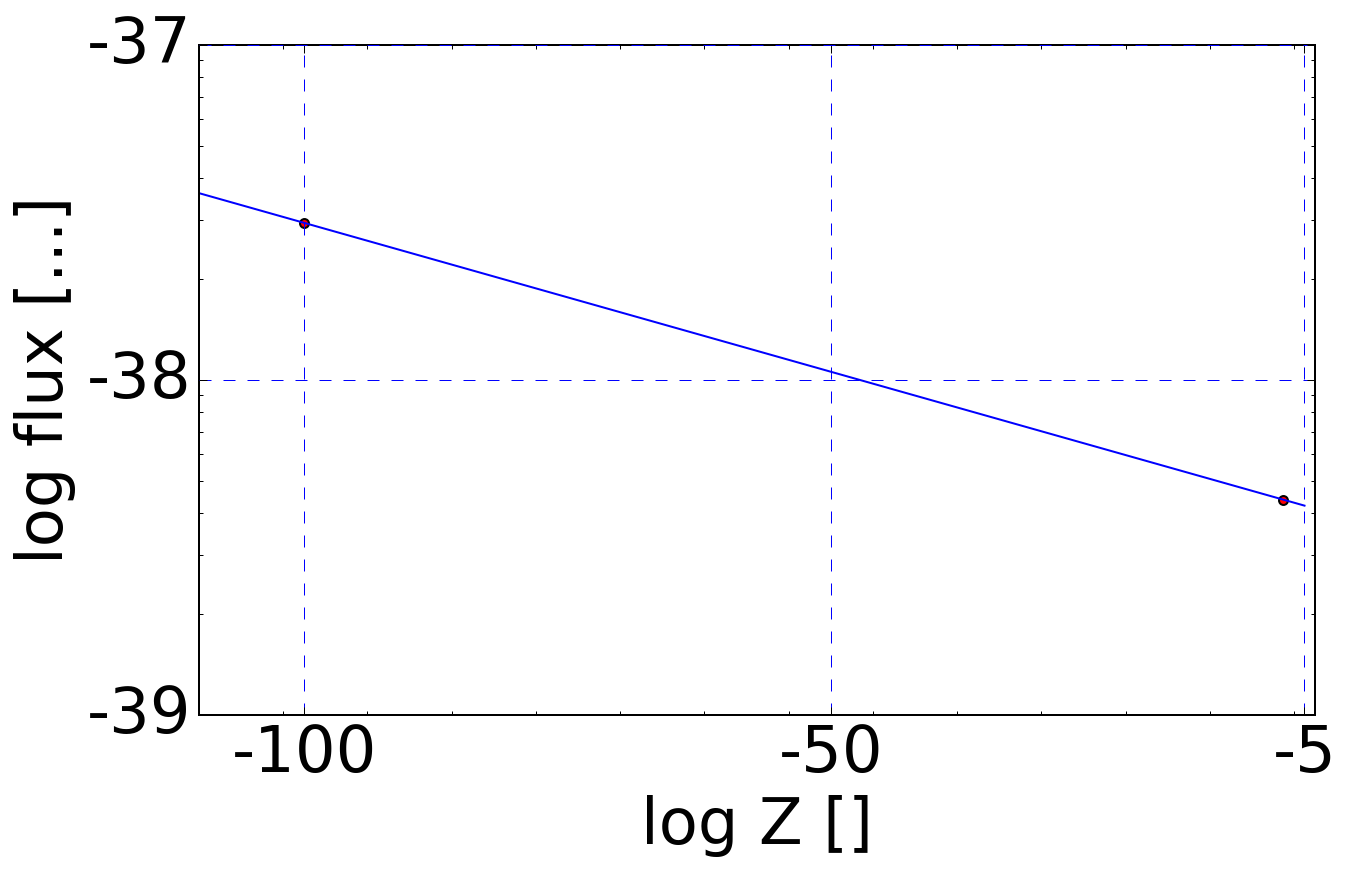

In [29]:
Zrng = np.logspace(-110,-5,100)

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(Zrng,filt335mInterp(Zrng),'b') # Plot star particles
ax.scatter([1e-100,1e-7],[pop3Flux14Interp(6.09458956),Zem7Flux14Interp(6.09458956)],s=20,c='r') # Plot star particles
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_xlabel('log Z []')
ax.set_ylabel('log flux [...]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
# ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
ax.set_xticks([1e-100,1e-50,1e-5])
# ax.set_ylim([-size/2,size/2])
    
gc.collect()

In [53]:
newFunc(-6)

array(nan)

In [50]:
newFunc = interp1d(np.log10([0,1e-5,1]),np.log10([10,1e3,1e2]),kind='linear')

/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


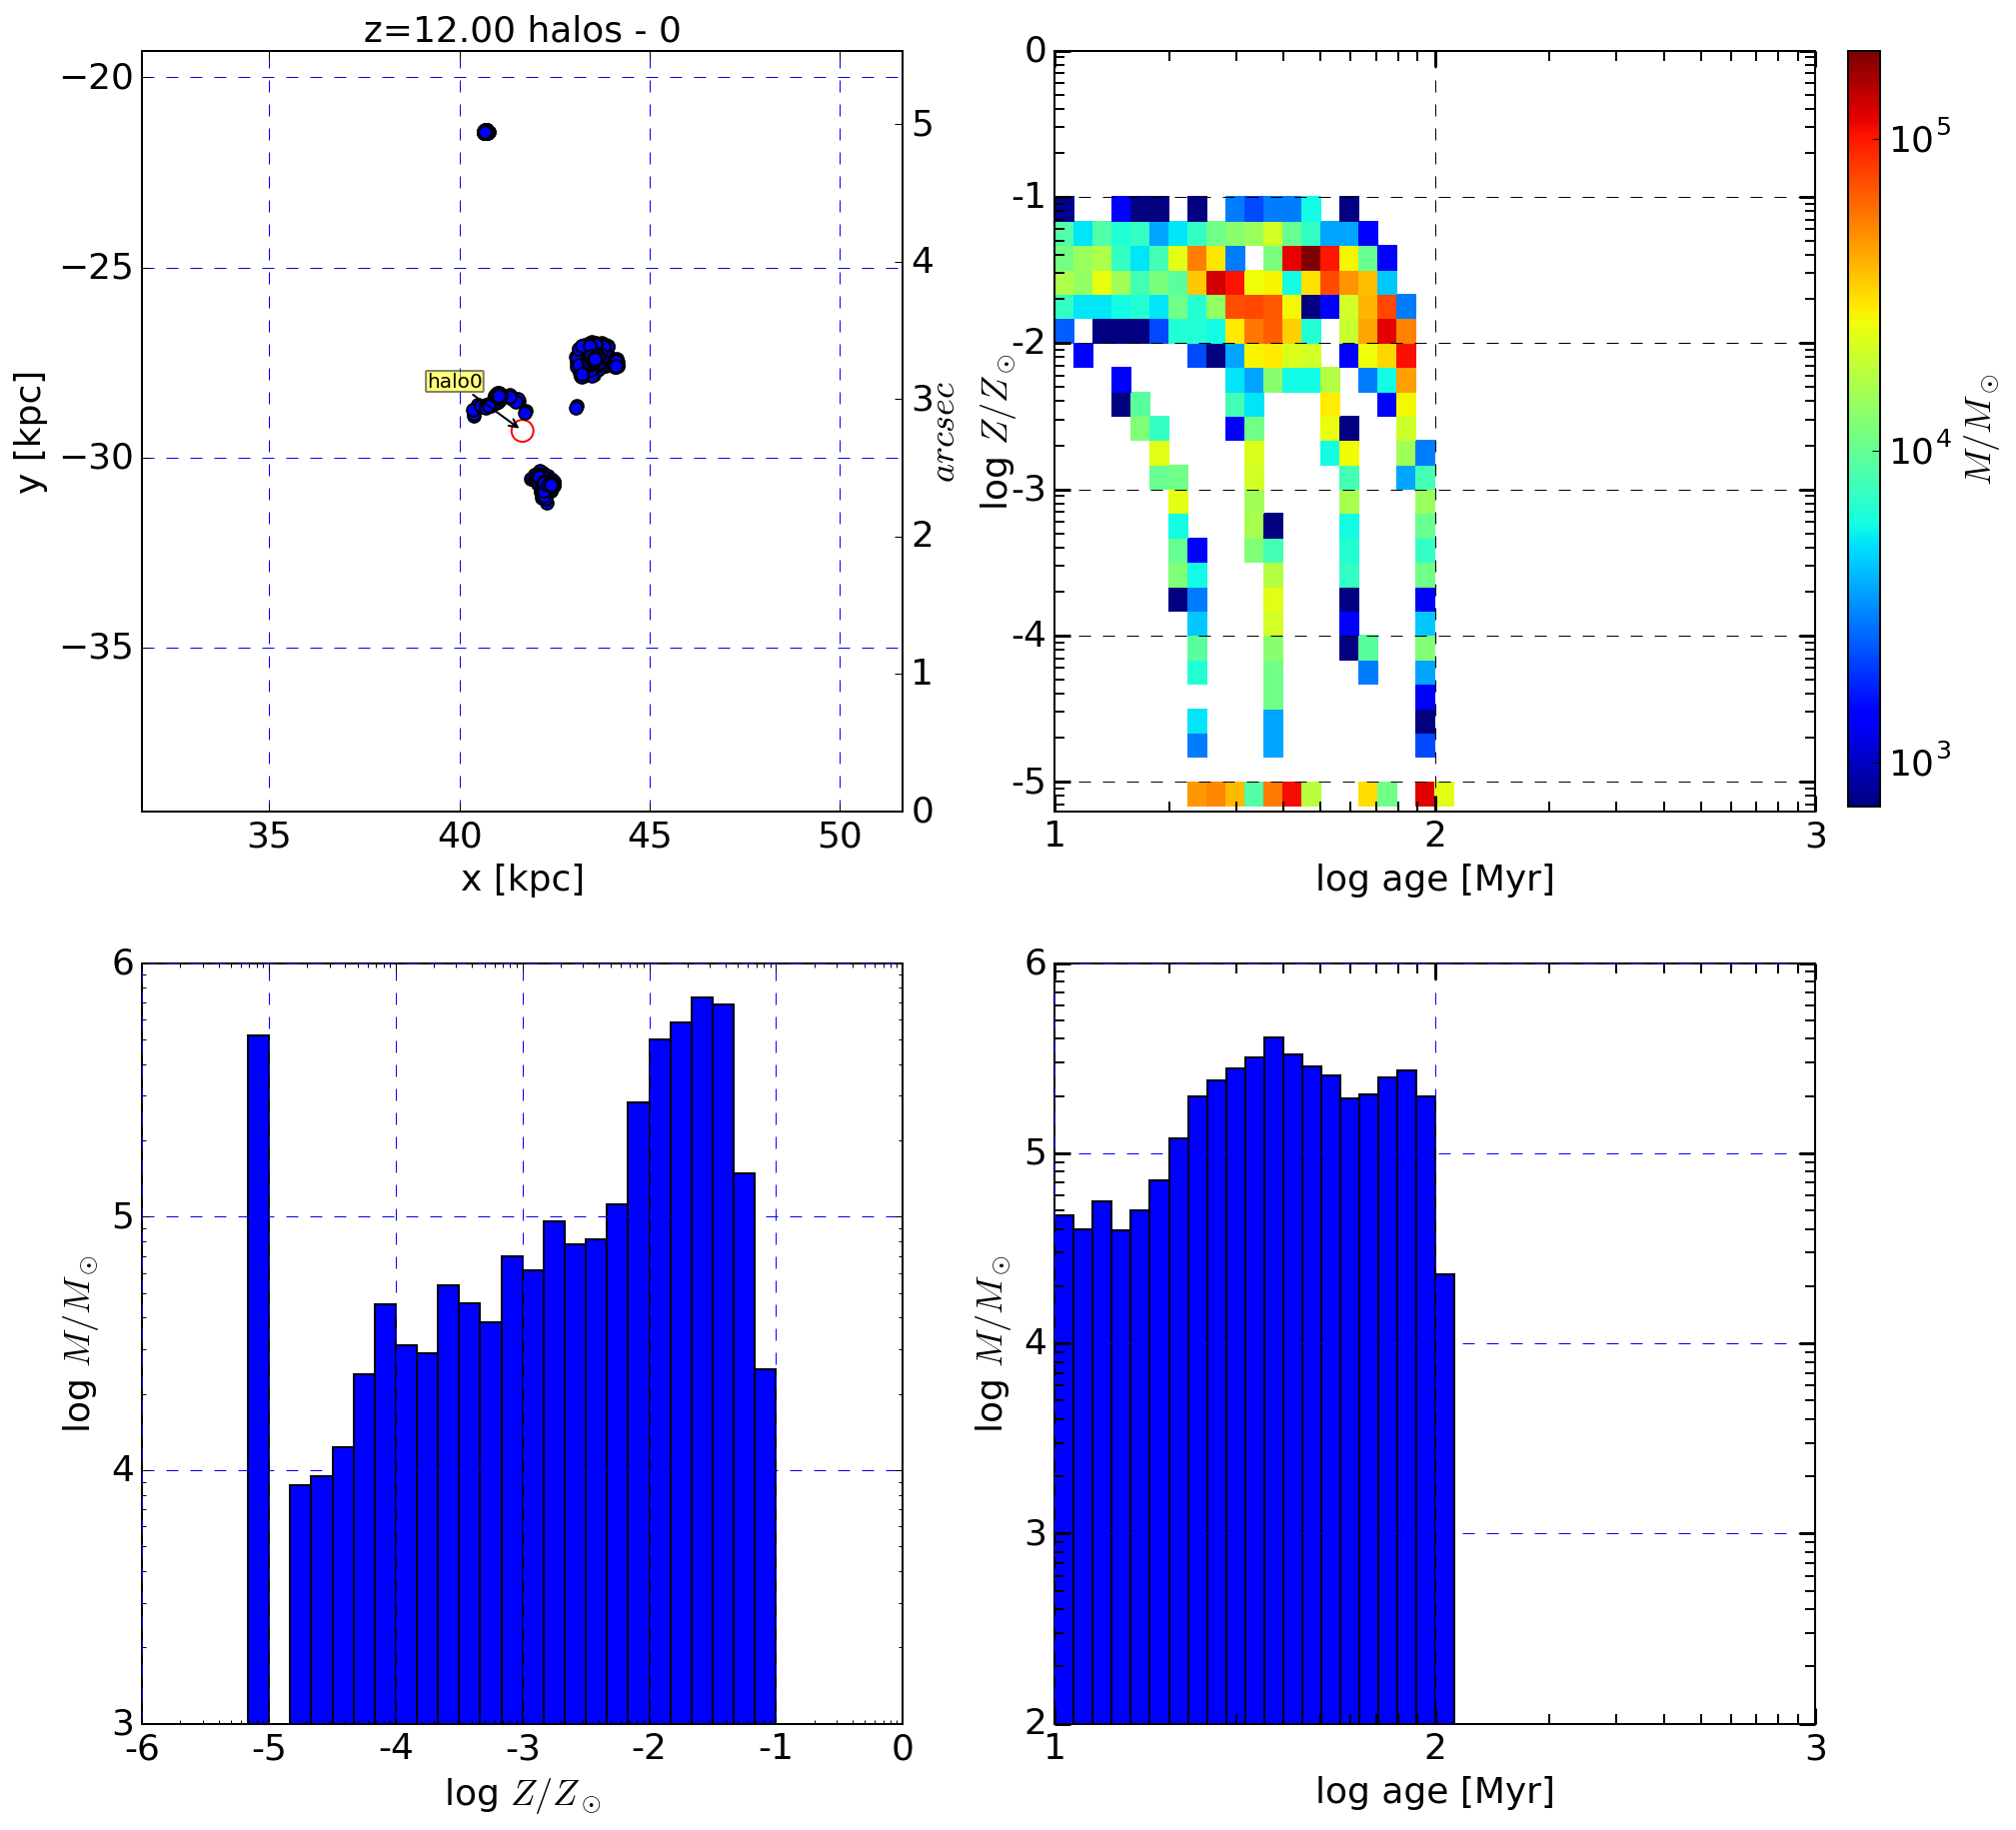

In [30]:
plt.rcParams['font.size'] = 18
cmap = plt.cm.jet
size = 10.0
for haloNum in range(0,1):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15, 15))
    #
    # Star particles for halo haloNum
    #

    arcSec = cosmo.arcAtz(71,z)

    #
    # Plot the halo star particles - scatter
    #
    size = 20
    hax=halos.pltView(locs,halosPos,haloNum,z,size,ax=ax1)
    origXlim=hax.get_xlim()
    origYlim=hax.get_ylim()

    # Add axis with arcsec scale
    hax2 = hax.twinx()
    hax2.set_ylim([0,size/arcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    hax.set_xlim(origXlim)
    hax.set_ylim(origYlim)

    # Load the stars for this halo
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)

    #
    # Metallicity of the halo star particles - histogram
    #
    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    ZBins   = np.logspace(-6,0,37)
    ax3.hist(Zfixed,bins=ZBins,weights=halomass)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.xaxis.set_major_formatter(logfmt)
    ax3.yaxis.set_major_formatter(logfmt)
    ax3.grid(b=True, which='major', color='b', linestyle='--')
    ax3.set_xlabel(r'log $Z/Z_\odot$')
    ax3.set_ylabel(r'log $M/M_\odot$')

    #
    # Age of halo star particles - histogram
    #
    ageBins = np.logspace(0,3,61) # TO match the SEDs we have from Schaerer, use 0.05 dex steps

    n, bins, patches = ax4.hist(haloages,bins=ageBins, weights=halomass)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.xaxis.set_major_formatter(logfmt)
    ax4.yaxis.set_major_formatter(logfmt)
    ax4.grid(b=True, which='major', color='b', linestyle='--')
    ax4.tick_params('both', length=5, width=1, which='minor')
    ax4.tick_params('both', length=8, width=1.5, which='major')
    ax4.set_xlabel('log age [Myr]')
    ax4.set_ylabel(r'log $M/M_\odot$')
    ax4.set_xlim([10,1000])
    
    #
    # 2D histogram, Z vs age
    #
    ageBins = np.logspace(0,3,61) # match the SEDs we have from Schaerer, use 0.05 dex steps

    Zfixed = haloZ
    Zfixed[Zfixed < 1e-5] = 10**-5.1

    # Can't use matplotlib with log axis... is screws it up.
    # n, aBins, metBins, image = ax.hist2d(ages,Zfixed,bins=(ageBins,ZBins),norm=LogNorm(),
    #                                    weights=mass)
    # Need to use numpy...
    n, aBins, metBins = np.histogram2d(Zfixed,haloages,bins=(ZBins,ageBins),
                                            weights=halomass)
    histax = ax2.pcolormesh(ageBins, ZBins, n, norm=LogNorm())

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.xaxis.set_major_formatter(logfmt)
    ax2.yaxis.set_major_formatter(logfmt)
    ax2.grid(b=True, which='major', color='k', linestyle='--')
    ax2.tick_params('both', length=5, width=1, which='minor')
    ax2.tick_params('both', length=8, width=1.5, which='major')
    ax2.set_xlabel(r'log age [Myr]')
    ax2.set_ylabel(r'log $Z/Z_\odot$')
    ax2.set_xlim([10,1000])
    ax2.set_ylim([10**-5.2,1])
    cax = fig.add_axes([0.915, 0.55, 0.015, 0.35])
    fig.colorbar(histax, cax=cax, label="$M/M_\odot$")
    ax2.yaxis.labelpad = -4

    #plt.subplots_adjust(left=0.15, bottom=0.1, right=0.84, top=.95, wspace=.1, hspace=.1)


# Real analysis... 


In [75]:
halospZ

array([ 0.00056234,  0.00067364,  0.00052184, ...,  0.00028395,
        0.00049795,  0.00063377])

In [76]:
halospages.min(),halospages.max(),len(halospZ)

(1.5451127259677264, 102.8607113086012, 5135)

In [77]:
# pop3Flux_14 = pd.read_csv('pop3TE_14.0.gz',dtype=float, delimiter=',')
# Zem7Flux_14 = pd.read_csv('Zem7_14.0.gz',dtype=float, delimiter=',')
# Zem5Flux_14 = pd.read_csv('Zem5_14.0.gz',dtype=float, delimiter=',')
# SB990004_14 = pd.read_csv('SB990004_14.0.gz',dtype=float, delimiter=',')
# SB99004_14 = pd.read_csv('SB99004_14.0.gz',dtype=float, delimiter=',')
# SB99008_14 = pd.read_csv('SB99008_14.0.gz',dtype=float, delimiter=',')
# SB9902_14  = pd.read_csv('SB9902_14.0.gz',dtype=float, delimiter=',')
# filternames = np.array(pop3Flux14).dtype.names[2::]

In [78]:
pop3Flux_14 = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',',names=True)
Zem7Flux_14 = np.genfromtxt('Zem7_14.0.gz',dtype=float, delimiter=',',names=True)
Zem5Flux_14 = np.genfromtxt('Zem5_14.0.gz',dtype=float, delimiter=',',names=True)
SB990004_14 = np.genfromtxt('SB990004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99004_14 = np.genfromtxt('SB99004_14.0.gz',dtype=float, delimiter=',',names=True)
SB99008_14 = np.genfromtxt('SB99008_14.0.gz',dtype=float, delimiter=',',names=True)
SB9902_14  = np.genfromtxt('SB9902_14.0.gz',dtype=float, delimiter=',',names=True)
filternames = np.array(pop3Flux14).dtype.names[2::]

In [79]:
print(filternames) # Just the filter names, skipped "LogAge" and "Z"

('f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


In [80]:
pop3Flux_14['f115w'][0:10],np.log10(pop3Flux_14['f115w'])[0:10]
# np.ma.masked_less_equal(pop3Flux_14[filt],0.0)

(array([  4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199,   4.81890000e-199,   4.81890000e-199,
          4.81890000e-199]),
 array([-198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209, -198.31705209, -198.31705209,
        -198.31705209, -198.31705209]))

In [122]:
#
# Generate interpolating functions for each metallicity over the age range computed for that Z
#
flux = {0:   {filt : interp1d(pop3Flux_14['LogAge'],
                              np.log10(np.ma.masked_less_equal(pop3Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-7: {filt : interp1d(Zem7Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem7Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       1e-5: {filt : interp1d(Zem5Flux_14['LogAge'],np.log10(np.ma.masked_less_equal(Zem5Flux_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-4: {filt : interp1d(SB990004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB990004_14[filt],0.0)),kind='linear') for filt in filternames},
       8e-3: {filt : interp1d(SB99008_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99008_14[filt],0.0)),kind='linear') for filt in filternames},
       4e-3: {filt : interp1d(SB99004_14['LogAge'],np.log10(np.ma.masked_less_equal(SB99004_14[filt],0.0)),kind='linear') for filt in filternames},
       2e-2: {filt : interp1d(SB9902_14['LogAge'],np.log10(np.ma.masked_less_equal(SB9902_14[filt],0.0)),kind='linear') for filt in filternames}
       }

In [82]:
#
# We have different age ranges, spacing for the different types of flux files...
pop3Flux_14['LogAge'][0:5], Zem7Flux_14['LogAge'][0:5], SB99008_14['LogAge'][0:5] , SB9902_14['LogAge'][0:5] 

(array([ 4.   ,  6.004,  6.303,  6.479,  6.603]),
 array([ 4.  ,  4.05,  4.1 ,  4.15,  4.2 ]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]),
 array([ 4.    ,  6.3032,  6.6031,  6.7789,  6.9036]))

In [83]:
print(10**flux[0]['F225W_WFC3']([4.,6.004]), 10**flux[1e-7]['F225W_WFC3']([4.,4.05]))
print(10**flux[8e-3]['f115w']([4.,6.3032]), 10**flux[8e-3]['Ks']([4.,6.3032]))

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


In [84]:
print(pop3Flux14['F225W_WFC3'][0:2], Zem7Flux_14['F225W_WFC3'][0:2])
print(SB99008_14['f115w'][0:2] , SB99008_14['Ks'][0:2])  # Matches our interpolators ... 

[  1.07530000e-82   5.78390000e-83] [  1.37360000e-86   1.37360000e-86]
[  4.81890000e-199   4.81890000e-199] [  4.79370000e-089   7.90850000e-199]


# The Algo

In [ ]:
redshifts    = [5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
haloFiles    = [241, 215, 191, 152, 136, 121, 108, 97, 84, 73, 58, 43, 33, 26, 20, 16]

In [ ]:
halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,0,10.0) # halo stars 10 kpc radius
halospZ  = halospZ * 0.02 # back to mass fraction
halospPZ = halospPZ * 0.02

In [ ]:
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos

import gc

###########################################################################################
# Generate filter flux from halos in simulation
# R. Sarmento
# 23 Aug 2016
#
# Loops over redshift files with stars and halo specs. Loops over each halo to compute the
# flux from each star particle as a function of age & Z. Totals flux in filter -- including
# flux due solely to PopIII stars -- and outputs the flux for each halo to a file.
###########################################################################################

# Constants for computing the virial radius of halos
# Use the cosmology from paper 1
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')

omDM   = 0.222 # From 27Aug15 sim: # = Om0 - Ob0 = 0.267 - 0.0449
h0     = 0.71
dmMass = 5.58e4 * omDM / h0               # Dark Matter particle mass [M_sun]
rho0DM = myCosmo.critical_density0 * omDM # Remember to use (1+z) factor to scale to redshift...


# Limit the number of halos considered...
# Based on an approx guess as to the upper lim for halos
# as a func of z. This way over-est, but keeps things from
# getting crazy.
# {{16, 250}, {11, 500}, {5, 1500}}
def maxHalos(z):
    return int(10 * z**2 - 336 * z + 2900)

#
# Compute the Total Mass in DM particles ...
#
def totMass(numParts):
    return dmMass * numParts * u.Msun

## File to z map... make sure halo infor is generated and the 'info_xxx' file exists.
## output_00007 z=18.12   output_00008 z=18.00   output_00011 z=17.00   output_00016 z=16.00  
## output_00020 z=15.00   output_00026 z=14.00   output_00033 z=13.00   output_00037 z=12.50  
## output_00043 z=12.00   output_00050 z=11.50   output_00058 z=11.00   output_00060 z=10.90  
## output_00066 z=10.50   output_00068 z=10.40   output_00073 z=10.00   output_00084 z=9.50  
## output_00097 z=9.00   output_00108 z=8.50   output_00121 z=8.00   output_00136 z=7.50  
## output_00152 z=7.00   output_00169 z=6.50   output_00191 z=6.00   output_00215 z=5.50  
## output_00237 z=5.07   output_00241 z=5.00   output_00243 z=4.98

#
# Process stars in halos... For each halo-center, find all stars within 15 kpc, comoving
# and compute the flux in all the filters for this object.
# R. Sarmento - 16 Aug 2016
#
sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
redshifts  = [5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
haloFiles  = [241, 215, 191, 169, 152, 136, 121, 108, 97, 84, 73, 58, 43, 33, 26, 20, 16]

# TEST TEST 
redshifts  = [ 6.0, 6.5, 7.0, 7.5, 8.0 ]
haloFiles  = [ 191, 169, 152, 136, 121 ]

redshifts  = [ 8.5, 9.0, 9.5, 10.0 ]
haloFiles  = [ 108, 97,  84,   73 ]

redshifts  = [ 16.0, 15.0, 14.0, 13.0, 12.0, 11.0 ]
haloFiles  = [ 16, 20, 26, 33, 43, 58 ]

magRef     = 48.6 # for AB system
fpolLim    = 1e-5

for z,num in zip(redshifts,haloFiles):
    print("##############################################")
    print("Processing z={:.1f}".format(z))
    print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
    boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1] # This is NOT per h ... It is 3Mpc/0.71/(1+z)

    locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z) # Z, PZ are in solar units... 
    print("Loaded star particles for output_{:05d}".format(num))
    print("Number of star particles in snap {}".format(len(PPF)))
    ##############################################
    # Need to correct the Z and PZ for the pristine
    # fraction of the SP... 
    ##############################################
    fpol = 1.0-PPF
    fpol[fpol < fpolLim] = 0.0 # Don't form polluted stars when fpol is very small
    ##############################################
    # Convert to mass fraction ... 
    ##############################################
    Z  = Z * 0.02
    PZ = PZ * 0.02
    if len(PZ[PZ > Z]):
        print("PZ > Z for {} particles".format(len(PZ[PZ > Z])))
        print("Diff - ",PZ[PZ > Z]-Z[PZ > Z])
        print("PZ - ",PZ[PZ > Z])
        print("Z  - ",Z[PZ > Z])
        PZ[PZ > Z] = Z[PZ > Z]
    ##############################################
    # Correct Z for polluted fraction. Use max
    # correction: Z_corr = <Z>/(1-PPF). Those at
    # -inf are placed below z_crit -> Pop III stars
    ##############################################
    Z_corr = Z/fpol
    Z_corr[np.isinf(Z_corr)]     = 1e-10 # Make the Z of these particles map to the Pop III flux dict indx
    Z_corr[Z_corr < 1e-5 * 0.02] = 1e-10 # 1e-5 is critical metallicity in solar units ... 
    ##################################################
    # Map ZP of sps < Z_crit to 0.0 
    ##################################################
    ZP_corr = PZ/fpol
    ZP_corr[np.isinf(ZP_corr)]     = 0.0 # Map to zero primordial fraction
    ZP_corr[ZP_corr < 1e-5 * 0.02] = 0.0
    ##################################################
    # TEMP fix until I generate flux files for Z > 0.02
    ##################################################
    if Z_corr.max() > 0.02:
        print("Super-solar stars ... {}".format(len(Z_corr[Z_corr>0.02])))
        Z_corr[Z_corr>0.02]   = 0.02
        ZP_corr[ZP_corr>0.02] = 0.02
    ##############################################
    # Compute star particle age based on current
    # epoch and star particle birth time.
    ##############################################
    baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
    print("Age at z={} is {:.1f} Myr".format(z,baseAge))    
    print("AstroPy Age at z={} is {:.1f}".format(z,myCosmo.age(z).to(u.Myr)))    
    spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
    print("min sp age {:.2f} Myr".format(min(spAges)))
    print("max sp age {:.2f} Myr".format(max(spAges)))
    print("min sp Z {:.2e}".format(min(Z)))
    print("max sp Z {:.2e}".format(max(Z)))
    print("min sp Z_corr {:.2e}".format(min(Z_corr)))
    print("max sp Z_corr {:.2e}".format(max(Z_corr)))
    if min(spAges) < 0.0:
        print(" ***** Error with sp age computation! *****")
        print(" Min Age: {:.2f}".format(min(spAges)))
        sys.exit()

    ##############################################
    # Load the halo locations & sizes (# dm particles)
    ##############################################
    halosRawPos = lsp.loadHaloGrps(num,
                    prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)
    halossizes = lsp.loadHaloSizes(num,
                    prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns DM particle counts for each halo
    
    ##############################################
    # Map halo coords to comoving coord. Map star
    # locations (orig physical at z) to comoving coord
    ##############################################
    halosPos = halosRawPos * 3000.0/h0      # Comoving coords for each halo
    locs = (locsRaw/boxsizekpc) * 3000.0/h0 # Comoving coords of SPs, they were orig physical at z... 
    print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

    ##############################################
    # Load the flux data for each Z over a range of ages.
    # Z is mass-fraction
    ##############################################
    pop3Flux = np.genfromtxt('pop3TE_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    Zem7Flux = np.genfromtxt('Zem7_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    Zem5Flux = np.genfromtxt('Zem5_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    SB990004 = np.genfromtxt('SB990004_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    SB99004  = np.genfromtxt('SB99004_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    SB99008  = np.genfromtxt('SB99008_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    SB9902   = np.genfromtxt('SB9902_{:.1f}.gz'.format(z),dtype=float, delimiter=',',names=True)
    filternames = np.array(pop3Flux).dtype.names[2::] # Cols 0-1 are Log Age, z, ... then filternames

    ###########################################################################################
    # NOTE flux files and interpolators are all in mass-fraction for metallicity
    # Also, we are interpolating in Log space -- so the x and y values are both log10(...)
    ###########################################################################################
    flux = {1e-10:   {filt : interp1d(pop3Flux['LogAge'],
                                  np.log10(pop3Flux[filt]),kind='linear') for filt in filternames},
           1e-7: {filt : interp1d(Zem7Flux['LogAge'],
                                  np.log10(Zem7Flux[filt]),kind='linear') for filt in filternames},
           1e-5: {filt : interp1d(Zem5Flux['LogAge'],
                                  np.log10(Zem5Flux[filt]),kind='linear') for filt in filternames},
           4e-4: {filt : interp1d(SB990004['LogAge'],
                                  np.log10(SB990004[filt]),kind='linear') for filt in filternames},
           8e-3: {filt : interp1d(SB99008['LogAge'],
                                  np.log10(SB99008[filt]),kind='linear') for filt in filternames},
           4e-3: {filt : interp1d(SB99004['LogAge'],
                                  np.log10(SB99004[filt]),kind='linear') for filt in filternames},
           2e-2: {filt : interp1d(SB9902['LogAge'],
                                  np.log10(SB9902[filt]),kind='linear') for filt in filternames}
           }
    # flux interpolators are used as follows: flux[Z][filtername](log10 age)

    gc.collect()
    filename = 'haloUVFluxes_z_{:.1f}_.txt'.format(z) 
    outfile  = [] # Empty list for output ... 
    numHalos = min(maxHalos(z),len(halosPos)) # The maxHalos func keeps us from considerings 5000+ halos.
    haloNum  = 0 # Since we skip empty halos, keep track of number actually processed
    processedHalos = [] # Keeps track of unique halos processed: unique halo => diff number of sps and/or total mass

    overDens    = 100.0 # For virial radius computation. Typical halo overdensity as compared to background rho
    denScaleFac = 0.90  # For virial radius ... fraction of the radius of the halo's overdensity radius to consider for sps
    haloCritRho = myCosmo.critical_density(z) * overDens * myCosmo.Odm(z) 
    
    ###########################################################################################
    # Loop over each halo -- process star particles -- determine/total flux
    ###########################################################################################
    for indx in range(numHalos):
##    for indx in np.arange(min(20,numHalos)): # TEST TEST
        # Compute virial radius and scale ... use as radius to find star particles
        radius = ((totMass(halossizes['count'][indx]) * 3.0/(4.0 * ma.pi) * 1.0/(haloCritRho))**(1.0/3.0)).to(u.kpc) * (1.0+z)
        radius = radius.value * denScaleFac # Radius of stars to include around halo center coord
        print(" ** Halo {} virial radius {:.2f}".format(indx,radius * u.kpc))
        halosplocs,halospmass,halospages,halospZ,halospPZ,halospFpol = halos.getHaloStars(locs,mass,spAges,Z_corr,ZP_corr,fpol,
                                                                              halosPos,indx,radius)
        halospages = halospages * 1e6 # Convert Myr to yr...

        ##################################################
        # spAges in yr
        # halospZ,halospPZ in mass-fraction and corrected
        # halosplocs in comoving coordinates
        ##################################################
        N = len(halospmass)
        if (N == 0):
            print(" ****** skipping halo {}, empty".format(indx))
            continue
        totHaloMass = np.sum(halospmass)
        if [N, totHaloMass] in processedHalos: # Make sure we aren't processing same halo (with diff indx)
            print(" ****** skipping halo {}, already processed ".format(indx))
            continue
        # If we get here, process the halo stars... 
        processedHalos.append([N,totHaloMass])

        print(" ** Working on halo {} with {} star particles & mass {:.2e} M_sun.".format(indx,N,totHaloMass))
        ##################################################
        # Initialize filter totals for this halo
        # We'll keep track of total flux in filter, and PopIII
        # flux in filter ... 
        ##################################################
        haloFiltTots      = dict.fromkeys([filt for filt in sorted(filternames)], 0.0) # Init with 0.0
        haloFiltTotPopIII = dict.fromkeys([filt for filt in sorted(filternames)], 0.0)
        haloFiltTotNoMix  = dict.fromkeys([filt for filt in sorted(filternames)], 0.0)
        
        # Build the output file header ... 
        headerStr  = 'indx, <Z>/Z_sun, <Z_P>/Z_sun, M/M_sun, '
        headerStr += ', '.join([f for f in sorted(haloFiltTots.keys())]) # Sorts by filter name
        headerStr += ', '
        headerStr += '_P3, '.join([f for f in sorted(haloFiltTotPopIII.keys())]) # Sorts by filter name
        headerStr += '_P3 '
        headerStr += ', '
        headerStr += '_NM, '.join([f for f in sorted(haloFiltTotNoMix.keys())]) # Sorts by filter name
        headerStr += '_NM '
        fmtStr = '%d, %.4e, %.4e, %.4e, '
        fmtStr += ', '.join(['%.4e' for ii in np.arange(3*len(filternames))])

        Zs = sorted(flux.keys()) # Get the list of indices (Zs) for the flux interp functions... 
        #####################################################################################################
        # Build a dictionary of interpolating functions for all of the unique sp (log) ages
        # for each filter, for each log Z
        #####################################################################################################
        uniqueAges = np.unique(np.log10(halospages)) # Log age in years... halospages is Myr!
        print("Number of unique star particle ages is {:.2e}".format(len(np.unique(halospages))))
        print("Min max star particle for interp {:.2f}, {:.2f} [Myr]".format(
                                                np.unique(halospages).min()/1e6,
                                                np.unique(halospages).max()/1e6))
        theFluxFuncs = { lspA: {filt : interp1d(np.log10([aZ for aZ in Zs]), # A list of log10(Zs)
                                       [flux[aZ][filt](lspA) for aZ in Zs],kind='linear') for filt in filternames} # A list of flux in Zs for filt at age=lspA
                                for lspA in uniqueAges  } # First index is log10(age [yrs]), next filt: results in func(log(Z))
        #####################################################################################################

        ##################################################
        # Loop over the star particles in the halo ...
        # Add up the flux in each filter...
        ##################################################
        for spZ,spAge,spMass,spFpol in zip(halospZ,np.log10(halospages),halospmass,halospFpol): # spZ is mass fraction, spAge is log10(age [yr])
            for filt in filternames:
                # So now theFluxFunc, f(log10(Z)), returns log10(flux). Each interpolator is valid at 'spAge' only
                
                thePolFluxForStar  = 10**theFluxFuncs[spAge][filt](np.log10(spZ))     # Fraction of polluted stars flux (1 M_sun)
                thePop3FluxForStar = 10**theFluxFuncs[spAge][filt](np.log10(1e-10))   # PopIII stars flux...

                # No mixing -- just use average spZ
                haloFiltTotNoMix[filt]  += thePolFluxForStar * spMass
                
                # The Pop III flux for the pristine part of this star particle... 
                haloFiltTotPopIII[filt] += thePop3FluxForStar * spMass * (1.0 - spFpol)

                # Always add the PopIII flux to the 'normal' star particle flux...
                haloFiltTots[filt]      += thePolFluxForStar * spMass * spFpol  +  haloFiltTotPopIII[filt] 
            # END PROCESS STARS IN HALO
            
        del theFluxFuncs
        gc.collect()            
        # Compute aveZ for the halo ... 
        aveZ = np.sum(halospmass * halospZ * spFpol)/np.sum(halospmass) # Remember halospZ is the corrected metallicity of the polluted fraction of the sp
        aveZ = aveZ / 0.02 # Back to solar units... 
        print("  Halo {} ave Z (solar) {:.2e}".format(indx,aveZ))
        
        # Compute the mass of stars' primordial metals
        # 1 - ppf is the polluted fraction of stars, by mass
        # pzf/Z is then the fraction of primordial metals
        # (1-ppf) * pzf / Z is hence the fraction of stars polluted only by primordial metals
        avePZ = np.sum(halospmass * spFpol * halospPZ/halospZ)/np.sum(halospmass) 
        avePZ = avePZ / 0.02 # Back to solar units... 
        print("  Halo {} ave PZ (solar) {:.2e}".format(indx,avePZ))

        values       = np.array( [haloFiltTots[i]      for i in sorted(haloFiltTots.keys())] )
        valuesPopIII = np.array( [haloFiltTotPopIII[i] for i in sorted(haloFiltTotPopIII.keys())] )
        valuesNoMix  = np.array( [haloFiltTotNoMix[i]  for i in sorted(haloFiltTotNoMix.keys())] )
        aLine = [haloNum] + [aveZ] + [avePZ] + [totHaloMass] + values.tolist() + valuesPopIII.tolist() + valuesNoMix.tolist()
        print("  Halo {} max flux in a filt {:.2e}".format(indx,values.max()))

        outfile.append(aLine)
        haloNum += 1
        gc.collect()
        # END PROCESS A HALO LOOP -- All galaxies at redshift z have now been processed
        
    print("Writing flux file... for z={}".format(z))
    np.savetxt(filename, np.array(outfile), fmt=fmtStr, delimiter=', ', header=headerStr) # (values) to get row-wise write
    # END PROCESS A REDSHIFT LOOP
    
print("Done")



Working on halo 0 with 5135 star particles.


In [252]:
haloFiltTots,haloFiltTots.values(),haloFiltTots.keys()

({'F098M_WFC3': 5.1142189943117767e-49,
  'F105W_WFC3': 2.9253715608920814e-49,
  'F125W_WFC3': 4.024907070328332e-51,
  'F160W_WFC3': 3.7913123154619525e-45,
  'F225W_WFC3': 6.7533825307963764e-83,
  'F275W_WFC3': 1.3459584045122573e-82,
  'F336W_WFC3': 7.6044022245489806e-80,
  'F435W_ACS': 2.7019733481801997e-79,
  'F606W_ACS': 2.706497651392722e-80,
  'F775W_ACS': 6.1341397865794829e-84,
  'F850LP_ACS': 0.0,
  'H': 0.0,
  'J': 0.0,
  'Ks': 3.6403867788124261e-84,
  'f070w': 4.1239414110809886e-82,
  'f090w': 0.0,
  'f115w': 0.0,
  'f140m': 2.2419376283931471e-49,
  'f150w': 3.0867708382878241e-45,
  'f162m': 1.0405446924835707e-40,
  'f182m': 7.5789235010414888e-34,
  'f200w': 1.185315317245489e-33,
  'f210m': 1.4455052907261807e-33,
  'f250m': 1.3349153933216445e-33,
  'f277w': 1.2619494209153849e-33,
  'f300m': 1.2025280399630223e-33,
  'f335m': 1.1424254265141286e-33,
  'f356w': 1.1128227512752334e-33,
  'f360m': 1.0949025519401954e-33,
  'f410m': 1.0482342077914067e-33,
  'f430

In [179]:
print(filternames)

('f360m', 'f162m', 'f300m', 'f356w', 'f480m', 'f444w', 'f460m', 'f210m', 'f200w', 'f115w', 'f070w', 'f140m', 'f150w', 'f430m', 'f410m', 'f090w', 'f250m', 'f277w', 'f182m', 'f335m', 'F606W_ACS', 'F105W_WFC3', 'F435W_ACS', 'F336W_WFC3', 'F850LP_ACS', 'F225W_WFC3', 'F160W_WFC3', 'F775W_ACS', 'F125W_WFC3', 'F098M_WFC3', 'F275W_WFC3', 'Ks', 'J', 'H')


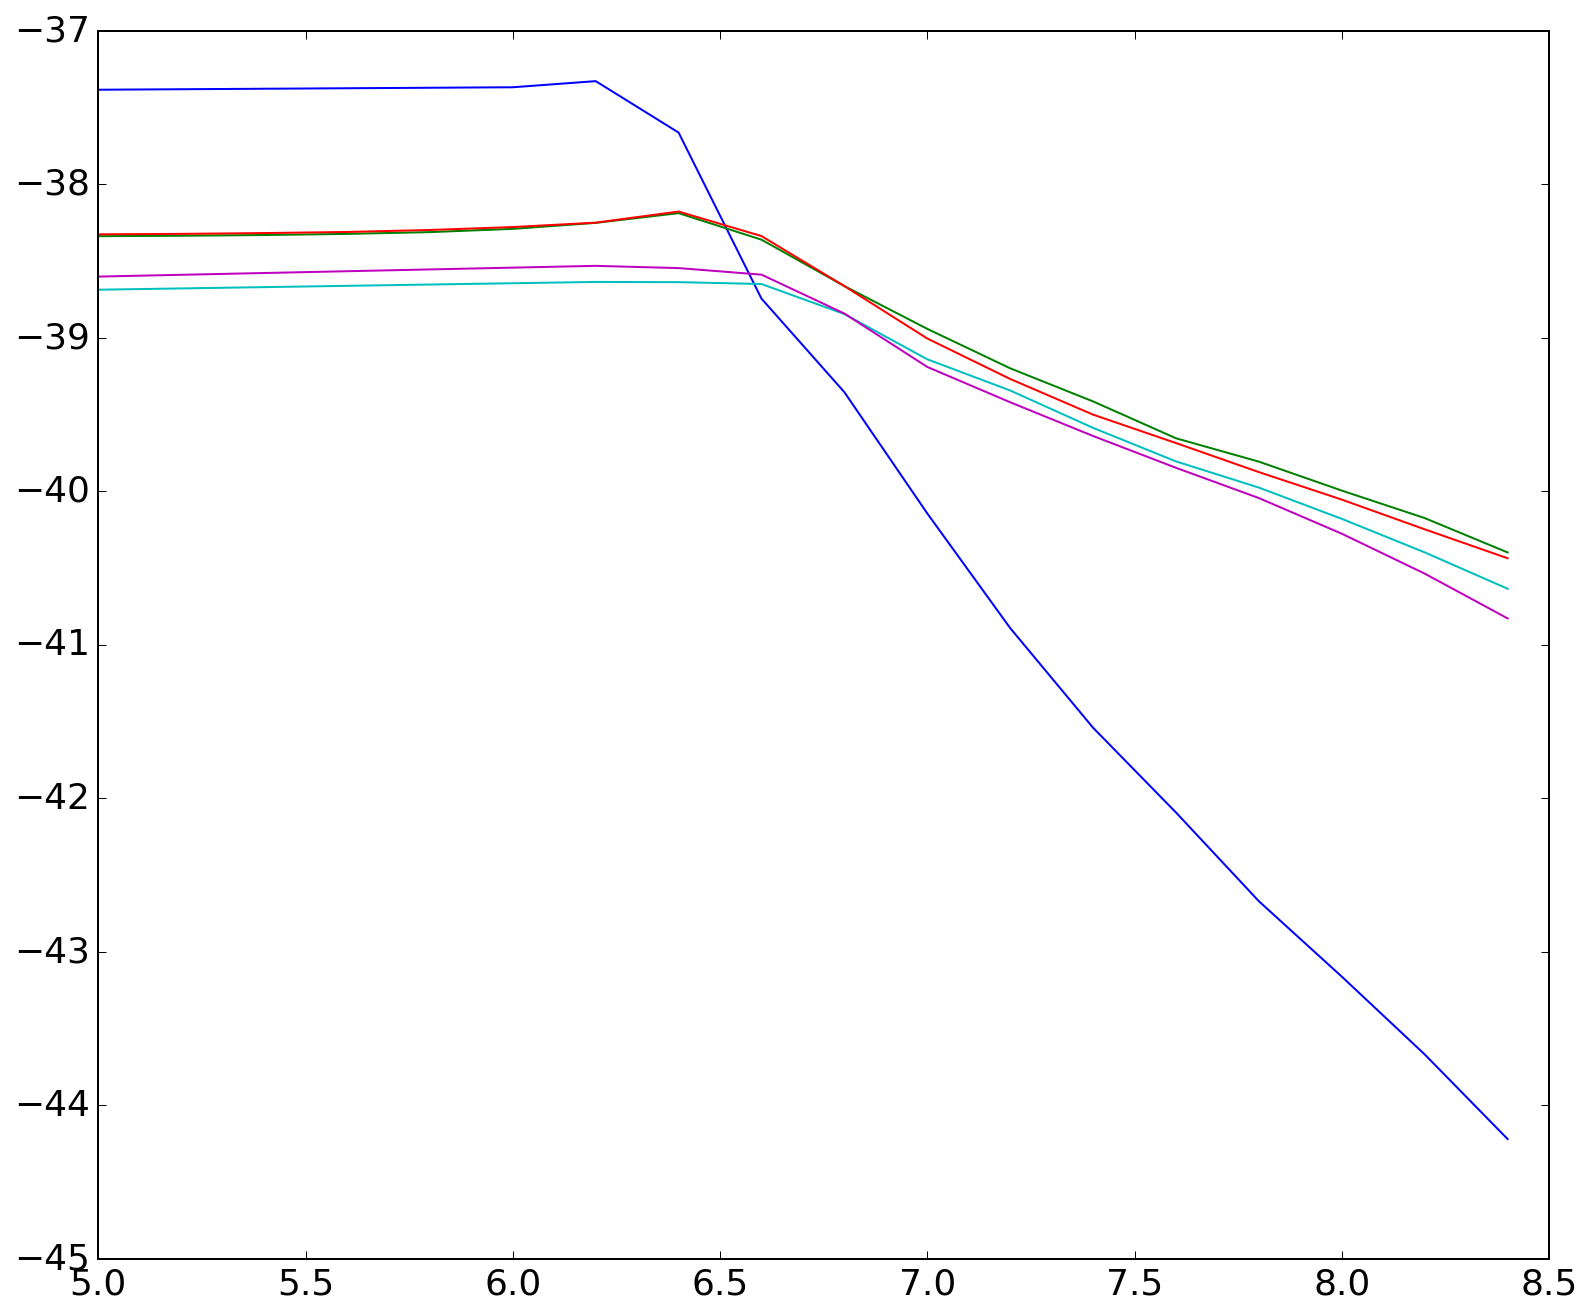

In [183]:
plt.plot(np.arange(5,8.6,0.2),flux[0]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[1e-7]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[1e-5]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[4e-3]['f430m'](np.arange(5,8.6,0.2)))
plt.plot(np.arange(5,8.6,0.2),flux[0.02]['f430m'](np.arange(5,8.6,0.2)))

In [142]:
spAge = 1e6
np.log10([spAge for i in Zs])

array([ 6.,  6.,  6.,  6.,  6.,  6.,  6.])

In [141]:
np.log10(halospages*1e6)

array([ 7.25826658,  7.31545708,  7.40218995, ...,  7.55637994,
        7.78737811,  7.69748605])

In [111]:
haloFiltTots['f115w'] += 1.0

In [125]:
flux[0]['f115w']

In [135]:
Zs = sorted(flux.keys())
for a in Zs:
    print("{:.1e}".format(a))

0.0e+00
1.0e-07
1.0e-05
4.0e-04
4.0e-03
8.0e-03
2.0e-02


In [129]:
sorted(flux.keys())

[0, 1e-07, 1e-05, 0.0004, 0.004, 0.008, 0.02]